In [4]:
import numpy as np
import seaborn as sns

In [66]:
bp_data = np.load('../../data/processed/BP_npy/PulseDB/test_sbp.npy')

# ラベリング関数の定義
def label_blood_pressure(bp):
    if bp <= 100:
        return 0    # 正常血圧
    elif 100 < bp < 120:
        return 1    # 正常血圧
    elif 120 < bp < 140:
        return 2    # 正常高値血圧
    else:
        return 3    # 高血圧

# ベクトル化した関数を作成
vectorized_label = np.vectorize(label_blood_pressure)

# データ全体にラベリングを適用
bp_labels = vectorized_label(bp_data)

In [67]:
print("ラベルの分布:")
unique, counts = np.unique(bp_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

ラベルの分布:
ラベル 0: 20674件
ラベル 1: 41043件
ラベル 2: 32447件
ラベル 3: 17436件


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import wandb
from sklearn.metrics import f1_score
from resnet1d import ResNet1D

In [55]:
from resnet1d import ResNet1D
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":4,
    },
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0304_4classes",
    "patience":10    
          }
model = ResNet1D(**config["network"])

In [56]:
model.load_state_dict(torch.load('..\\outputs\\resnet\\0304_4class\\best.pth'))
model.to(device)
model.eval()


ResNet1D(
  (first_block_conv): MyConv1dPadSame(
    (conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  )
  (first_block_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_block_relu): ReLU()
  (basicblock_list): ModuleList(
    (0-3): 4 x BasicBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.5, inplace=False)
      (conv1): MyConv1dPadSame(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (do2): Dropout(p=0.5, inplace=False)
      (conv2): MyConv1dPadSame(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (max_pool): MyMaxPool1dPadSame(
        (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (4): BasicBlock(
      (bn1): 

In [ ]:
torch._utils


AttributeError: module 'torch' has no attribute '_utils'

### dataset

In [8]:
from resnet1d import ResNet1D
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0408_2class_cv_res18",
    "patience":10    
          }
model = ResNet1D(**config["network"])

In [ ]:
class BPDataset(Dataset):
    def __init__(self, data_dir,train=True):
        # Load data
        if train:
            # self.x = np.load(f'{data_dir}/train_raw.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/train_sbp_4labels.npy')  # Shape: (-1,)
            self.x = np.load(f'{data_dir}/train_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.y = np.load(f'{data_dir}/train_sbp.npy')  # Shape: (-1,)
            self.y = 
        else:
            # self.x = np.load(f'{data_dir}/test_raw.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/test_sbp_4labels.npy')  # Shape: (-1,)
            self.x = np.load(f'{data_dir}/test_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.y = np.load(f'{data_dir}/test_sbp.npy')  # Shape: (-1,)
        
        # Convert to torch tensors
        self.x = torch.FloatTensor(self.x)
        self.y = torch.LongTensor(self.y)
        print(self.x.shape,self.y.shape)
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [60]:
# データセットとDataLoaderの作成
data_dir = '../../data/processed/BP_npy/PulseDB'
batch_size = 32

# train_dataset = BPDataset(data_dir,train=True)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BPDataset(data_dir,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# トレーニングデータの確認
# x, y = train_dataset[0]
# print("Training data:")
# print(f"x shape: {x.shape}, x dtype: {x.dtype}")
# print(f"y shape: {y.shape}, y dtype: {y.dtype}")
# print(f"Unique labels in training: {torch.unique(train_dataset.y)}")

# テストデータの確認
x, y = test_dataset[0]
print("\nTest data:")
print(f"x shape: {x.shape}, x dtype: {x.dtype}")
print(f"y shape: {y.shape}, y dtype: {y.dtype}")
print(f"Unique labels in test: {torch.unique(test_dataset.y)}")

torch.Size([111600, 1, 1250]) torch.Size([111600])

Test data:
x shape: torch.Size([1, 1250]), x dtype: torch.float32
y shape: torch.Size([]), y dtype: torch.int64
Unique labels in test: tensor([0, 1, 2, 3])


# def calculate_metrics 

In [43]:
def calculate_metrics(y_true, y_pred,classes=2):
        # 正解率
        accuracy = np.mean(y_true == y_pred)
        
        # クラスごとの精度を計算
        class_accuracies = []
        for cls in range(classes):
            mask = (y_true == cls)
            if np.sum(mask) > 0:
                class_acc = np.sum((y_true == y_pred) & mask) / np.sum(mask)
                class_accuracies.append(class_acc)
            else:
                raise ValueError(f"Class {cls} has no samples.")
        
        # マクロ平均F1スコア
        f1_macro = f1_score(y_true, y_pred, average='macro')
        
        return accuracy, class_accuracies, f1_macro

# test

In [61]:
all_y_true = []
all_y_pred = []
val_loader_tqdm = tqdm(test_dataloader, desc=f"Epoch {1 + 1}/{100} - Validation", leave=False)
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for batch_idx, (x,y) in enumerate(val_loader_tqdm):

        x,y = x.to(device), y.to(device)
        outputs = model(x)
        # loss_mae = mae(outputs, gt)
        # if batch_idx % config.log_interval == 0:
        #     wandb.log({"test_loss_step": loss.item()})
        # # if batch_idx  == 0:
        # #     wandb.log({"val/loss": log_img(gt,outputs)})
        # val_loss += loss.item()
        # val_loss_mae += loss_mae.item()
        _, predicted = torch.max(outputs.data, 1)
        all_y_true.extend(y.cpu().numpy())
        all_y_pred.extend(predicted.cpu().numpy())
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])


In [62]:
accuracy,f1

(0.399094982078853, 0.4015729158039383)

In [63]:
from sklearn.metrics import confusion_matrix
import pandas as pd
pd.options.display.precision = 4 # 表示桁数の設定

conf_mat = confusion_matrix(all_y_true, all_y_pred, normalize='true')
display(pd.DataFrame(conf_mat))

0       1       2       3
0  0.5671  0.2667  0.1104  0.0559
1  0.3332  0.3400  0.2335  0.0933
2  0.1592  0.2858  0.3586  0.1964
3  0.0868  0.1511  0.3478  0.4143

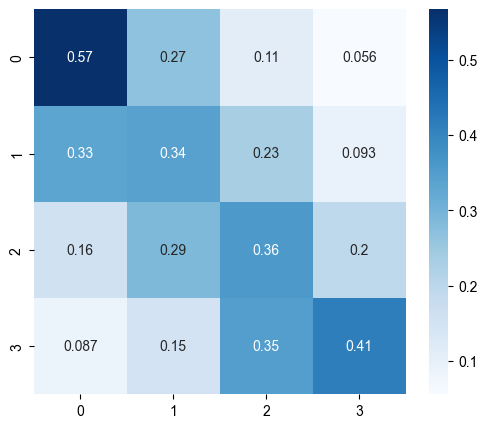

In [64]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial' # フォントを指定
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, cmap = 'Blues', annot=True)
plt.show()

## cv


In [ ]:
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-4,
    "batch_size": 16,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0415_2class_cv_res18mini",
    "patience":5    
}

In [ ]:
from se_resnet1d import resnet34,se_resnet34,resnet18,resnet18mini
model = resnet18mini(num_classes=config["network"]["n_classes"], in_channels=config["network"]["in_channels"])

In [ ]:
from dataset import BPDataset
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import wandb
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
data_dir = '../../data/processed/BP_npy/PulseDB'
checkpoint_dir =config["output_path"]
batch_size = config["batch_size"]
test_dataset = BPDataset(data_dir,train=False)
f1s = []
for fold in range(5):
    # データセットとDataLoaderの作成
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # load checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'best_fold{fold}.pth')
    model.load_state_dict(torch.load(checkpoint_path))
    with torch.no_grad():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()

        all_y_true = []
        all_y_pred = []
        all_y_pred_proba = []
        # 進捗バーの設定
        val_loader_tqdm = tqdm(test_dataloader, desc=f"Fold {fold+1}/{5} - Test", leave=False)
        for batch_idx, (x,y) in enumerate(val_loader_tqdm):
            x,y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            all_y_pred_proba.extend(outputs.cpu().numpy())
            # 予測確率を取得
            all_y_true.extend(y.cpu().numpy())
            all_y_pred.extend(predicted.cpu().numpy())
        all_y_true = np.array(all_y_true)
        all_y_pred = np.array(all_y_pred)
        all_y_pred_proba = np.array(all_y_pred_proba)
    # 予測結果の保存
    np.save(f'{checkpoint_dir}\\predictions_fold{fold}.npy', all_y_pred)
    # 正解ラベルの保存
    np.save(f'{checkpoint_dir}\\true_labels_fold{fold}.npy', all_y_true)
    # 予測確率の保存
    np.save(f'{checkpoint_dir}\\predictions_proba_fold{fold}.npy', all_y_pred_proba)
    # calculate metrics
    accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])
    print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    f1s.append(f1)
    # plot confusion matrix
    conf_mat = confusion_matrix(all_y_true, all_y_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap = 'Blues', annot=True)
    plt.title(f'Fold {fold+1} - Confusion Matrix')
    plt.savefig(f'{checkpoint_dir}\\confusion_matrix_fold{fold}.png')
    plt.close()
print(np.array(f1s).mean())

torch.Size([38110, 1, 1250]) torch.Size([38110])


Fold 1 - Accuracy: 0.8047, F1 Score: 0.8038


Fold 2 - Accuracy: 0.7993, F1 Score: 0.7986


Fold 3 - Accuracy: 0.8003, F1 Score: 0.7991


Fold 4 - Accuracy: 0.7971, F1 Score: 0.7967


Fold 5 - Accuracy: 0.8072, F1 Score: 0.8065
0.8009534138368508


### load test results

In [44]:
def metrics_all_fold(checkpoint_dir, n_classes=2):
    accuracy_list = []
    f1_list = []
    for fold in range(5):
        # load predictions
        all_y_pred = np.load(f'{checkpoint_dir}\\predictions_fold{fold}.npy')
        all_y_true = np.load(f'{checkpoint_dir}\\true_labels_fold{fold}.npy')
        accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred, classes=n_classes)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy_list, f1_list

In [ ]:
checkpoint_dir = config["output_path"]
n_classes = config["network"]["n_classes"]

In [ ]:
print("Metrics for",os.path.basename(checkpoint_dir))
accuracy_list, f1_list = metrics_all_fold(checkpoint_dir, n_classes=n_classes)

Metrics for 0331_2class_cv_res34
Fold 1 - Accuracy: 0.8230, F1 Score: 0.8214
Fold 2 - Accuracy: 0.8024, F1 Score: 0.8013
Fold 3 - Accuracy: 0.7932, F1 Score: 0.7910
Fold 4 - Accuracy: 0.8056, F1 Score: 0.8043
Fold 5 - Accuracy: 0.7991, F1 Score: 0.7971


In [ ]:
me

In [ ]:
fold = 0

pred = np.load(f'{checkpoint_dir}\\predictions_fold{fold}.npy')
pred_proba = np.load(f'{checkpoint_dir}\\predictions_proba_fold{fold}.npy')
true_labels = np.load(f'{checkpoint_dir}\\true_labels_fold{fold}.npy')




### check sSqi

In [ ]:
correct = np.where(pred == true_labels)[0]
incorrect = np.where(pred != true_labels)[0]
test_data = np.load(f'../../data/processed/BP_npy/PulseDB/test_2.npy')

Text(0.5, 1.0, 'Skewness of Correct and Incorrect Predictions')

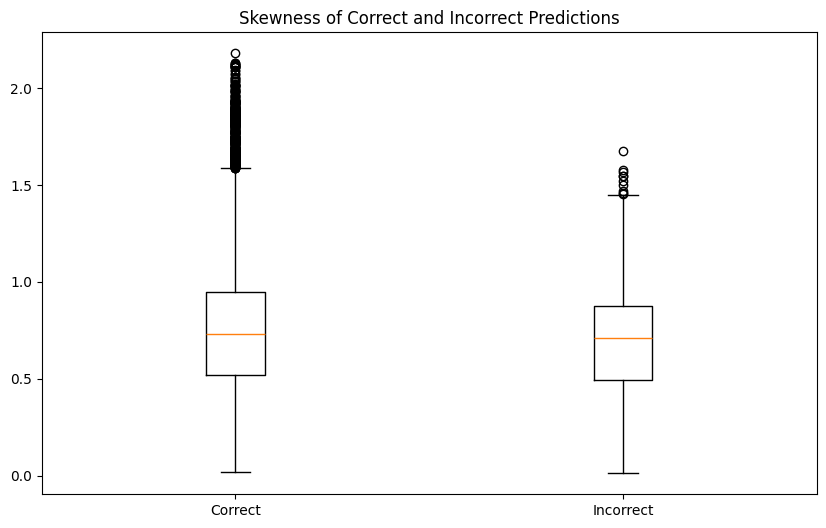

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
skew_correct = stats.skew(test_data[correct,1], axis=1)
skew_incorrect = stats.skew(test_data[incorrect,1], axis=1)
# boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([skew_correct, skew_incorrect], labels=['Correct', 'Incorrect'])
plt.title('Skewness of Correct and Incorrect Predictions')


In [ ]:
print(np.std(skew_correct),np.std(skew_incorrect))

0.3212311642498526 0.27149631551984976


In [ ]:
from scipy.stats import ttest_ind

# aとbが独立した群で正規分布前提
stat, p = ttest_ind(skew_correct, skew_incorrect, equal_var=False)  # Welchのt検定
print("p値:", p)

p値: 2.5041297039384584e-66


In [ ]:
from scipy.stats import shapiro

# aとbが1次元のデータ配列
stat_a, p_a = shapiro(skew_correct)
stat_b, p_b = shapiro(skew_incorrect)

print("aのShapiro検定 p値:", p_a)
print("bのShapiro検定 p値:", p_b)

if p_a > 0.05:
    print("aは正規分布とみなせる")
else:
    print("aは正規分布とは言えない")

if p_b > 0.05:
    print("bは正規分布とみなせる")
else:
    print("bは正規分布とは言えない")

aのShapiro検定 p値: 0.0
bのShapiro検定 p値: 9.768134825480321e-17
aは正規分布とは言えない
bは正規分布とは言えない


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
def calculate_correlation(data):
    n = data.shape[0]
    correlations = np.zeros(n)
    for a in range(n):
        # Compute the correlation coefficient between data[a, 0, :] and data[a, 1, :]
        corr = np.corrcoef(data[a, 1, :], data[a, 0, :])[0, 1]
        correlations[a] = corr
    
    return correlations

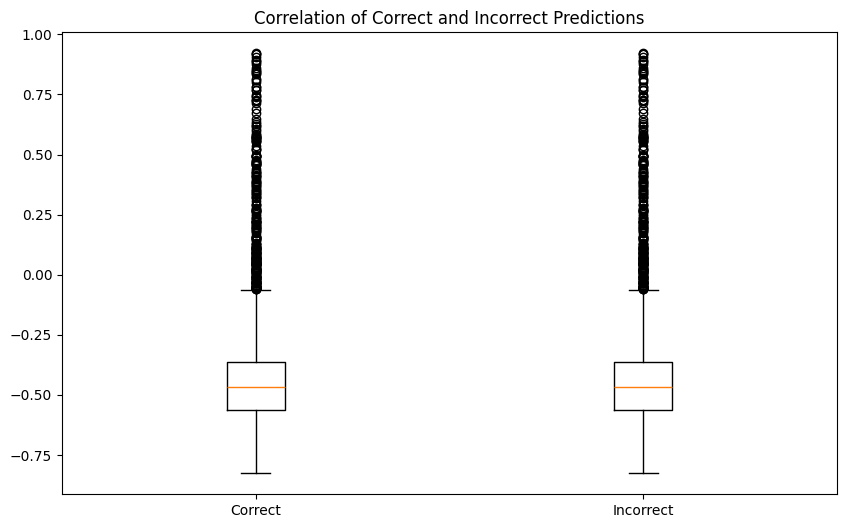

In [ ]:
# 相関係数
corr_correct = calculate_correlation(test_data[correct])
corr_incorrect = corr_correct = calculate_correlation(test_data[incorrect])
plt.figure(figsize=(10, 6))
plt.boxplot([corr_correct, corr_incorrect], labels=['Correct', 'Incorrect'])
plt.title('Correlation of Correct and Incorrect Predictions')
plt.show()

### count number

In [ ]:
np.unique(true_labels, return_counts=True)

(array([0, 1], dtype=int64), array([20674, 17436], dtype=int64))

In [ ]:
Fold 1 - Accuracy: 0.7960, F1 Score: 0.7960
                                                                     
Fold 2 - Accuracy: 0.7850, F1 Score: 0.7850
                                                                     
Fold 3 - Accuracy: 0.8000, F1 Score: 0.7997
                                                                     
Fold 4 - Accuracy: 0.8054, F1 Score: 0.8051
                                                                     
Fold 5 - Accuracy: 0.8072, F1 Score: 0.8071

# regr


In [ ]:
class BPDataset_Regr(Dataset):
    def __init__(self, data_dir,train=True):
        # Load data
        if train:
            self.x = np.load(f'{data_dir}/train.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.sbp = np.load(f'{data_dir}/train_sbp.npy')  # Shape: (-1,)
            self.dbp = np.load(f'{data_dir}/train_dbp.npy')  # Shape: (-1,)
            # self.x = np.load(f'{data_dir}/train_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/train_sbp_2labels.npy')  # Shape: (-1,)
        else:
            self.x = np.load(f'{data_dir}/test.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.sbp = np.load(f'{data_dir}/test_sbp.npy')  # Shape: (-1,)
            self.dbp = np.load(f'{data_dir}/test_dbp.npy')  # Shape: (-1,)
            # self.x = np.load(f'{data_dir}/test_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/test_sbp_2labels.npy')  # Shape: (-1,)
        scale = np.load(f'{data_dir}/scale_train.npy')
        self.sbp = self.sbp * scale[0,1]- scale[0,0]
        self.dbp = self.dbp * scale[0,1] - scale[0,0]

        # Convert to torch tensors
        self.x = torch.FloatTensor(self.x)
        self.sbp = torch.FloatTensor(self.sbp)
        self.dbp = torch.FloatTensor(self.dbp)
        print(self.x.shape,self.sbp.shape,self.dbp.shape)
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.sbp[idx],self.dbp[idx]


In [ ]:
# データセットとDataLoaderの作成
data_dir = '../../data/processed/BP_npy/PulseDB'
batch_size = 32

# train_dataset = BPDataset(data_dir,train=True)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BPDataset_Regr(data_dir,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([111600, 1, 1250]) torch.Size([111600]) torch.Size([111600])


In [ ]:
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0308_regr",
    "patience":10    
          }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet1D(**config["network"])
model.load_state_dict(torch.load('..\\outputs\\resnet\\0308_regr\\best_fold0.pth'))
model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for ResNet1D:
	size mismatch for first_block_conv.conv.weight: copying a param with shape torch.Size([64, 1, 5]) from checkpoint, the shape in current model is torch.Size([64, 1, 3]).
	size mismatch for basicblock_list.0.conv1.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.0.conv2.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.1.conv1.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.1.conv2.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.2.conv1.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.2.conv2.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.3.conv1.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.3.conv2.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.4.conv1.conv.weight: copying a param with shape torch.Size([128, 64, 5]) from checkpoint, the shape in current model is torch.Size([128, 64, 3]).
	size mismatch for basicblock_list.4.conv2.conv.weight: copying a param with shape torch.Size([128, 128, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 3]).

In [ ]:
config["epochs"] 

100

In [ ]:
val_loader = test_dataloader
all_y_true = []
all_y_pred = []
val_loader_tqdm = tqdm(val_loader)
with torch.no_grad():
    for batch_idx, (x,sbp,dbp) in enumerate(val_loader_tqdm):

        x,sbp,dbp = x.to(device), sbp.to(device),dbp.to(device)
        outputs = model(x)
        # val_loss_mae += loss_mae.item()
        all_y_true.extend(np.array([sbp.cpu().numpy(),dbp.cpu().numpy()]))
        all_y_pred.extend(np.array([outputs[:,0].cpu().numpy(),outputs[:,1].cpu().numpy()]))
all_y_true = np.concatenate(all_y_true,axis=0).reshape(-1,2)
all_y_pred = np.concatenate(all_y_pred,axis=0).reshape(-1,2)
# print(all_y_true.shape,all_y_pred.shape)
# accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])


100%|██████████| 3488/3488 [00:15<00:00, 219.69it/s]


In [ ]:
import numpy as np
scale = np.load('../../data/processed/BP_npy/PulseDB/scale_train.npy')
1/scale[0,1]

284.2411394163927

In [ ]:
error = (all_y_true - all_y_pred)
scale = np.load('../../data/processed/BP_npy/PulseDB/scale_train.npy')
error = (error - scale[0,0])/scale[0,1]
error[1]

NameError: name 'all_y_true' is not defined

In [ ]:
error.shape

(111600, 2)

In [ ]:
error_5.shape

(111600,)

In [ ]:

mse = np.mean(error**2,axis=0)
rmse = np.sqrt(mse)
me = np.mean(error,axis=0)
mae = np.mean(np.abs(error),axis=0)
std = np.std(error,axis=0)
n_samples = len(test_dataset)
(me.shape,mae.shape,rmse.shape,std.shape)
error_5 = np.count_nonzero(np.abs(error)<=5,axis=0)/n_samples*100
error_15 = np.count_nonzero(np.abs(error)<=15,axis=0)/n_samples*100
error_10 = np.count_nonzero(np.abs(error)<=10,axis=0)/n_samples*100

In [ ]:
print("""
          test data samples:
          # samples : {}
          
          Eval Stats:   DBP    SBP
          MAE:        {:6.3f} {:6.3f}
          RMSE:       {:6.3f} {:6.3f}
          Mean Error: {:6.3f} {:6.3f}
          STD:        {:6.3f} {:6.3f}
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
          SBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
           
          
          """.format(
            n_samples,
            *mae,
            *rmse,
            *me,
            *std,
            error_5[0], error_10[0], error_15[0],
            error_5[1], error_10[1], error_15[1],
          ))


          test data samples:
          # samples : 111600
          
          Eval Stats:   DBP    SBP
          MAE:        11.901 11.929
          RMSE:       15.566 15.606
          Mean Error:  3.869  3.949
          STD:        15.078 15.098
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      27.7%   52.3%   70.7%
          SBP      27.8%   52.1%   70.5%
           
          
          


# Grad-CAM


In [1]:
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]],device=output.device)
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

In [67]:
from resnet1d import ResNet1D
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0228",
    "ppg":10    
          }
model = ResNet1D(**config["network"])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
model.load_state_dict(torch.load('..\\outputs\\resnet\\0228\\best.pth'))
model.to(device)
model.eval()
# 


ResNet1D(
  (first_block_conv): MyConv1dPadSame(
    (conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  )
  (first_block_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_block_relu): ReLU()
  (basicblock_list): ModuleList(
    (0-3): 4 x BasicBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.5, inplace=False)
      (conv1): MyConv1dPadSame(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (do2): Dropout(p=0.5, inplace=False)
      (conv2): MyConv1dPadSame(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (max_pool): MyMaxPool1dPadSame(
        (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (4): BasicBlock(
      (bn1): 

In [8]:
id_to_label = {0: 'normal', 1: 'high'}


In [ ]:
grad_cam = 

SyntaxError: invalid syntax (1291206013.py, line 1)

In [12]:
data_dir = '../../data/processed/BP_npy/PulseDB'
batch_size = 32

test_dataset = BPDataset(data_dir,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([38110, 1, 1250]) torch.Size([38110])


In [13]:
def plot_cam(cam, y,title=None):
    y=y.squeeze()
    heatmap_image = np.tile(cam, (20, 1))  # 高さ20ピクセル相当のストライプ
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(0,10,0.008)
    # imshowで背景にヒートマップを表示
    ax.imshow(
        heatmap_image,
        extent=[x.min(), x.max(), y.min() - 0.1, y.max() + 0.1],
        aspect='auto',
        cmap='RdYlBu_r',
        alpha=0.5,  # 透明度
        origin='lower'
    )
    ax.set_title(title)
    # 波形のプロット
    ax.plot(x, y, color='black')
    ax.set_xlim(x.min(), x.max())
    plt.tight_layout()
    plt.show()


In [71]:
def grad_cam_plot(model,idx):
    grad_cam = GradCAM(model=model, feature_layer=model.basicblock_list[-1])
    input_tensor = test_dataset[idx][0].unsqueeze(0).to(device)
    # print("true:",test_dataset[idx][1].cpu().numpy(),"pred:",grad_cam.forward(input_tensor),nn.Softmax(dim=1)(grad_cam.forward(input_tensor)))
    model_output = grad_cam.forward(input_tensor)
    target = model_output.argmax(1).item()
    grad_cam.backward_on_target(model_output, target)
    # Get feature gradient
    feature_grad = grad_cam.feature_grad.data.cpu().numpy()[0]
    print(feature_grad.shape)
    # Get weights from gradient
    weights = np.mean(feature_grad, axis=1)  # Take averages for each gradient
    # Get features outputs
    feature_map = grad_cam.feature_map.data.cpu().numpy()
    grad_cam.clear_hook()
    cam = np.sum((weights * feature_map.T), axis=1).T
    cam = np.maximum(cam, 0)  # apply ReLU to cam
    cam = (cam-cam.min())/(cam.max()-cam.min())
    plot_cam(cam,input_tensor.cpu().numpy()[0],title=f"true:{test_dataset[idx][1].cpu().numpy()},pred:{nn.Softmax(dim=1)(grad_cam.forward(input_tensor)).detach().cpu().numpy()[0]}")
    return cam

(128, 1250)


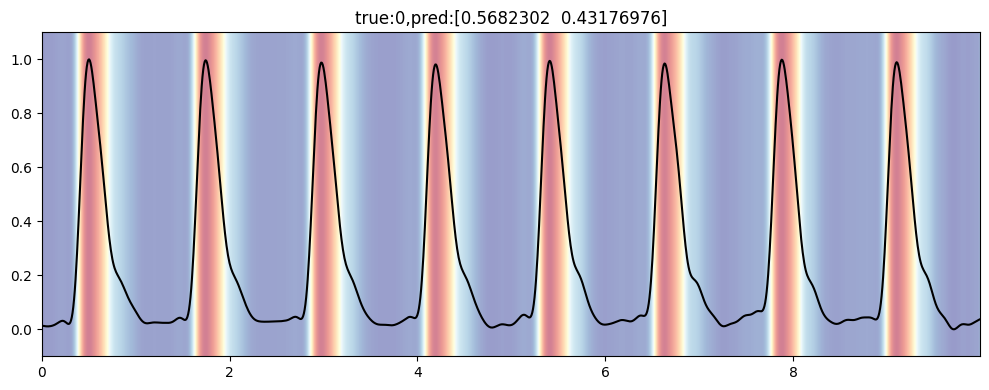

0.9644468247890472

In [74]:
model = model.to(device)
model.eval()
a = grad_cam_plot(model, 1666)
np.percentile(a, 95)

In [111]:
from tqdm import tqdm,trange
def get_grad_cam_all(model,target=0):
    all_cams = []
    test_dataset = BPDataset('../../data/processed/BP_npy/PulseDB', train=False)
    grad_cam = GradCAM(model=model, feature_layer=model.basicblock_list[-1])
    for idx in trange(len(test_dataset), desc="Calculating Grad-CAMs"):
        # print(f"Processing index {idx}/{len(test_dataset)}")
        input_tensor = test_dataset[idx][0].unsqueeze(0).to(device)
        model_output = grad_cam.forward(input_tensor)
        target = target
        
        grad_cam.backward_on_target(model_output, target)
        # Get feature gradient
        feature_grad = grad_cam.feature_grad.data.cpu().numpy()[0]
        # Get weights from gradient
        weights = np.mean(feature_grad, axis=1)  # Take averages for each gradient
        # Get features outputs
        feature_map = grad_cam.feature_map.data.detach().cpu().numpy()

        cam = np.sum((weights * feature_map.T), axis=1).T
        cam = np.maximum(cam, 0)  # apply ReLU to cam
        cam = (cam-cam.min())/(cam.max()-cam.min()+ 1e-8)  # Avoid division by zero
        all_cams.append(cam)
        # del input_tensor, model_output, feature_grad, feature_map, cam
        # torch.cuda.empty_cache()
        # gc.collect()
    grad_cam.clear_hook()
    return np.array(all_cams)
    

In [89]:
del input_tensor, model_output, feature_grad, weights, feature_map, cam

NameError: name 'input_tensor' is not defined

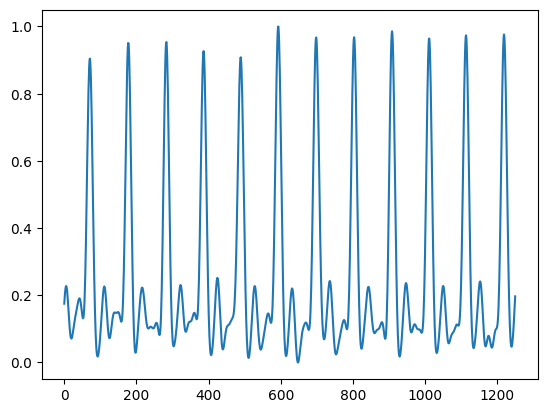

In [58]:
plt.plot(test_dataset[2000
                      ][0].squeeze().cpu().numpy())

In [94]:
model = ResNet1D(**config["network"])
model.load_state_dict(torch.load('..\\outputs\\resnet\\0228\\best.pth'))
model.to(device)    
model.eval()

ResNet1D(
  (first_block_conv): MyConv1dPadSame(
    (conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  )
  (first_block_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_block_relu): ReLU()
  (basicblock_list): ModuleList(
    (0-3): 4 x BasicBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.5, inplace=False)
      (conv1): MyConv1dPadSame(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (do2): Dropout(p=0.5, inplace=False)
      (conv2): MyConv1dPadSame(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (max_pool): MyMaxPool1dPadSame(
        (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (4): BasicBlock(
      (bn1): 

In [118]:
all_cams = [get_grad_cam_all(model,target=0), get_grad_cam_all(model,target=1)]

torch.Size([38110, 1, 1250]) torch.Size([38110])


Calculating Grad-CAMs:   0%|          | 0/38110 [00:00<?, ?it/s]f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Calculating Grad-CAMs: 100%|██████████| 38110/38110 [06:26<00:00, 98.52it/s] 


torch.Size([38110, 1, 1250]) torch.Size([38110])


Calculating Grad-CAMs: 100%|██████████| 38110/38110 [06:16<00:00, 101.20it/s]


In [115]:
a = np.percentile(all_cams, 95,axis=1)
a.shape

(38110,)

In [84]:
import gc
gc.collect()

5241

In [ ]:
ha

In [86]:
del grad_cam
gc.collect()
torch.cuda.empty_cache()

NameError: name 'grad_cam' is not defined

In [85]:
torch.cuda.empty_cache()

In [ ]:
  # Welchのt検定

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


TtestResult(statistic=nan, pvalue=nan, df=38108.0)

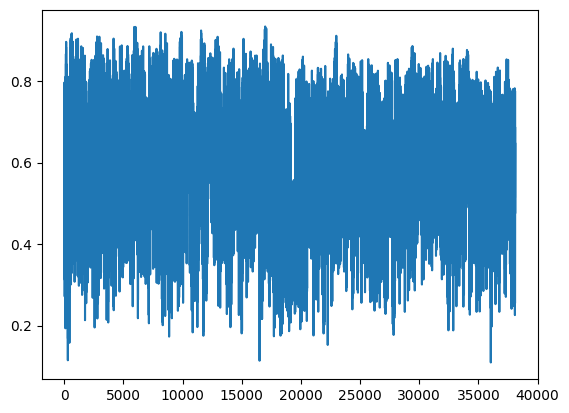

In [116]:
plt.plot(a)

In [62]:
plt.plot(all_cams[20]-all_cams[200])

IndexError: index 200 is out of bounds for axis 0 with size 100

(array([    0.,     0.,     0.,     0.,     0., 38110.,     0.,     0.,
            0.,     0.]),
 array([0.22731308, 0.32731308, 0.42731308, 0.52731308, 0.62731308,
        0.72731308, 0.82731308, 0.92731308, 1.02731308, 1.12731308,
        1.22731308]),
 <BarContainer object of 10 artists>)

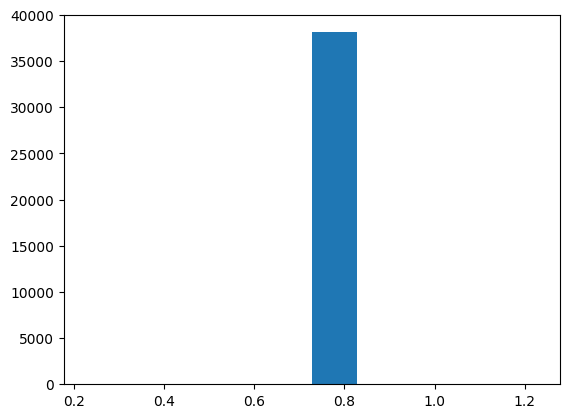

In [371]:
plt.hist(a)

In [117]:
all_cams = np.array(all_cams)
np.save('..\\outputs\\resnet\\0228\\grad_cam.npy', all_cams)

In [314]:
all_cams.shape

(2, 38110, 1250)

In [27]:
import pandas as pd
ppg_segments = pd.read_parquet("../../data/processed/parquet/pulsedb_gradcam_features_test.parquet")
ppg_segments.shape,ppg_segments.head()


((376408, 6),
    signal_index   A1   A2   A3   A4   A0
 0             0   72   83  110  134   59
 1             0  147  158  184  209  134
 2             0  222  234  258  284  209
 3             0  298  309  333  359  284
 4             0  373  384  411  434  359)

In [64]:
all_y_true = test_dataset.y.cpu().numpy()
all_y_true.shape

(38110,)

In [69]:
len(ppg_segments)

376408

In [105]:
np.unique(all_y_true, return_counts=True)

(array([0, 1], dtype=int64), array([20674, 17436], dtype=int64))

In [100]:
all_y_true

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [309]:
mean_storage_0 = [ [ [] for _ in range(4) ] for _ in range(2) ]  # 2ラベル×4区間

for label in range(2):
    for seg in range(4):
        for gradcam_arr in data_storage_0[label][seg]:
            mean_storage_0[label][seg].append(np.mean(gradcam_arr))

In [ ]:
for label in range(2):
    for seg in range(4):
        for gradcam_arr in data_storage_0[label][seg]:
            mean_storage_0[label][seg].append(np.mean(gradcam_arr))

In [120]:
all_y_true = test_dataset.y.cpu().numpy()

In [132]:
data_storage_0 =  [[[]for i in range(4)]for j in range(2)]  # 0: A0, 1: A1, 2: A2, 3: A3
data_storage_1 =  [[[]for i in range(4)]for j in range(2)]  # 0: A0, 1: A1, 2: A2, 3: A3
print(len(data_storage_1))

i = -1
pbar = tqdm(total=len(ppg_segments), desc="Processing PPG Segments")
while i < len(ppg_segments)-1:
    i += 1
    pbar.update(1)
    # data_storage_0[all_y_true[ppg_segments.iloc[i]["signal_index"]]][0].append()
    # data_storage_0[all_y_true[ppg_segments.iloc[i]["signal_index"]]][1].append(all_cams[0][ppg_segments.iloc[i]["signal_index"],ppg_segments.iloc[i]["A1"]:ppg_segments.iloc[i]["A2"]].copy())
    # data_storage_0[all_y_true[ppg_segments.iloc[i]["signal_index"]]][2].append(all_cams[0][ppg_segments.iloc[i]["signal_index"],ppg_segments.iloc[i]["A2"]-5:ppg_segments.iloc[i]["A2"]+5].copy())
    # data_storage_0[all_y_true[ppg_segments.iloc[i]["signal_index"]]][3].append(all_cams[0][ppg_segments.iloc[i]["signal_index"],ppg_segments.iloc[i]["A3"]-5:ppg_segments.iloc[i]["A3"]+5].copy())
    # mean with same signal index
    signal_index_save = ppg_segments.iloc[i]["signal_index"]
    tmp_0 = []
    tmp_1 = []
    tmp_2 = []
    tmp_3 = []
    while signal_index_save == ppg_segments.iloc[i]["signal_index"] and i < len(ppg_segments)-1:
        tmp_0.append(all_cams[1][ppg_segments.iloc[i]["signal_index"],ppg_segments.iloc[i]["A0"]:ppg_segments.iloc[i]["A1"]].copy())
        tmp_1.append(all_cams[1][ppg_segments.iloc[i]["signal_index"],ppg_segments.iloc[i]["A1"]:ppg_segments.iloc[i]["A2"]].copy())
        tmp_2.append(all_cams[1][ppg_segments.iloc[i]["signal_index"],ppg_segments.iloc[i]["A2"]:ppg_segments.iloc[i]["A3"]].copy())
        tmp_3.append(all_cams[1][ppg_segments.iloc[i]["signal_index"],ppg_segments.iloc[i]["A3"]:ppg_segments.iloc[i]["A4"]].copy())
        i += 1
        pbar.update(1)
    tmp_0 = [item for sublist in tmp_0 for item in sublist]
    tmp_1 = [item for sublist in tmp_1 for item in sublist]
    tmp_2 = [item for sublist in tmp_2 for item in sublist]
    tmp_3 = [item for sublist in tmp_3 for item in sublist]
    # tmp_0 = np.mean(np.array(tmp_0),axis=0)
    # tmp_1 = np.mean(np.array(tmp_1),axis=0) 
    # tmp_2 = np.mean(np.array(tmp_2),axis=0)
    # tmp_3 = np.mean(np.array(tmp_3),axis=0) 
    # 95% percentile
    tmp_0 = np.percentile(tmp_0, 95)
    tmp_1 = np.percentile(tmp_1, 95)
    tmp_2 = np.percentile(tmp_2, 95)
    tmp_3 = np.percentile(tmp_3, 95)
    # print(all_y_true[ppg_segments.iloc[i]["signal_index"]])
    data_storage_1[all_y_true[ppg_segments.iloc[i]["signal_index"]]][0].append(tmp_0)
    data_storage_1[all_y_true[ppg_segments.iloc[i]["signal_index"]]][1].append(tmp_1)
    data_storage_1[all_y_true[ppg_segments.iloc[i]["signal_index"]]][2].append(tmp_2)
    data_storage_1[all_y_true[ppg_segments.iloc[i]["signal_index"]]][3].append(tmp_3)
    

2


Processing PPG Segments: 100%|█████████▉| 375909/376408 [01:03<00:00, 6275.66it/s]

In [140]:
len(data_storage_1)

2

In [ ]:
all_cams

In [332]:
all_cams.shape

(2, 38110, 1250)

In [ ]:
cam_95_0 = []
cam_95_1 = []
for i in trange(len(all_cams[1])):
    print(all_cams[1][i].shape)
    percentile_95 = np.percentile(all_cams[1][i], 95)
    # print(f"Signal {i}, Percentile 95: {percentile_95}")
    if all_y_true[i] == 0:
        cam_95_0.append(percentile_95)
    else:
        cam_95_1.append(percentile_95)

 11%|█▏        | 4301/38110 [00:00<00:01, 21187.40it/s]

(1250,)
Signal 0, Percentile 95: 0.7273130834102629
(1250,)
Signal 1, Percentile 95: 0.5257361084222794
(1250,)
Signal 2, Percentile 95: 0.35042133182287216
(1250,)
Signal 3, Percentile 95: 0.4558927729725838
(1250,)
Signal 4, Percentile 95: 0.4516261592507361
(1250,)
Signal 5, Percentile 95: 0.40071009397506696
(1250,)
Signal 6, Percentile 95: 0.544547215104103
(1250,)
Signal 7, Percentile 95: 0.3615629002451896
(1250,)
Signal 8, Percentile 95: 0.5704386919736861
(1250,)
Signal 9, Percentile 95: 0.34421164393424974
(1250,)
Signal 10, Percentile 95: 0.7967003911733627
(1250,)
Signal 11, Percentile 95: 0.4023252159357071
(1250,)
Signal 12, Percentile 95: 0.4267887189984321
(1250,)
Signal 13, Percentile 95: 0.4214124307036398
(1250,)
Signal 14, Percentile 95: 0.4619636863470077
(1250,)
Signal 15, Percentile 95: 0.7884729206562042
(1250,)
Signal 16, Percentile 95: 0.32168517708778377
(1250,)
Signal 17, Percentile 95: 0.7629758358001709
(1250,)
Signal 18, Percentile 95: 0.49481659233570086

 17%|█▋        | 6420/38110 [00:00<00:01, 20708.27it/s]

(1250,)
Signal 4301, Percentile 95: 0.5197212904691696
(1250,)
Signal 4302, Percentile 95: 0.7207815825939178
(1250,)
Signal 4303, Percentile 95: 0.7240138113498688
(1250,)
Signal 4304, Percentile 95: 0.6721758216619491
(1250,)
Signal 4305, Percentile 95: 0.7946961909532546
(1250,)
Signal 4306, Percentile 95: 0.6539540231227875
(1250,)
Signal 4307, Percentile 95: 0.7698832899332047
(1250,)
Signal 4308, Percentile 95: 0.5313990592956542
(1250,)
Signal 4309, Percentile 95: 0.6959583789110181
(1250,)
Signal 4310, Percentile 95: 0.5744878709316253
(1250,)
Signal 4311, Percentile 95: 0.7520510166883468
(1250,)
Signal 4312, Percentile 95: 0.7598062932491302
(1250,)
Signal 4313, Percentile 95: 0.5469004392623901
(1250,)
Signal 4314, Percentile 95: 0.5502963125705719
(1250,)
Signal 4315, Percentile 95: 0.7420768380165098
(1250,)
Signal 4316, Percentile 95: 0.7873231828212738
(1250,)
Signal 4317, Percentile 95: 0.7031470447778702
(1250,)
Signal 4318, Percentile 95: 0.7366550922393799
(1250,)
Si

 34%|███▎      | 12822/38110 [00:00<00:01, 21242.55it/s]

Signal 8489, Percentile 95: 0.8114824980497358
(1250,)
Signal 8490, Percentile 95: 0.7708396524190902
(1250,)
Signal 8491, Percentile 95: 0.8001334935426712
(1250,)
Signal 8492, Percentile 95: 0.7324569523334503
(1250,)
Signal 8493, Percentile 95: 0.8566066294908522
(1250,)
Signal 8494, Percentile 95: 0.8310354471206663
(1250,)
Signal 8495, Percentile 95: 0.781892567873001
(1250,)
Signal 8496, Percentile 95: 0.5724451959133148
(1250,)
Signal 8497, Percentile 95: 0.8097252786159514
(1250,)
Signal 8498, Percentile 95: 0.7196663975715634
(1250,)
Signal 8499, Percentile 95: 0.6877663195133209
(1250,)
Signal 8500, Percentile 95: 0.7600654304027556
(1250,)
Signal 8501, Percentile 95: 0.7550882816314697
(1250,)
Signal 8502, Percentile 95: 0.8155356466770168
(1250,)
Signal 8503, Percentile 95: 0.6499246388673774
(1250,)
Signal 8504, Percentile 95: 0.73431998193264
(1250,)
Signal 8505, Percentile 95: 0.7211169987916944
(1250,)
Signal 8506, Percentile 95: 0.7955753594636916
(1250,)
Signal 8507, 

 45%|████▍     | 17116/38110 [00:00<00:00, 21246.14it/s]

(1250,)
Signal 12822, Percentile 95: 0.7338181883096695
(1250,)
Signal 12823, Percentile 95: 0.7637753278017043
(1250,)
Signal 12824, Percentile 95: 0.7506130963563918
(1250,)
Signal 12825, Percentile 95: 0.7956207513809204
(1250,)
Signal 12826, Percentile 95: 0.7624362081289291
(1250,)
Signal 12827, Percentile 95: 0.6932186663150787
(1250,)
Signal 12828, Percentile 95: 0.8206260919570922
(1250,)
Signal 12829, Percentile 95: 0.7379484087228775
(1250,)
Signal 12830, Percentile 95: 0.7976000219583511
(1250,)
Signal 12831, Percentile 95: 0.7306419193744659
(1250,)
Signal 12832, Percentile 95: 0.6826446712017059
(1250,)
Signal 12833, Percentile 95: 0.7243291467428207
(1250,)
Signal 12834, Percentile 95: 0.7628403931856154
(1250,)
Signal 12835, Percentile 95: 0.7241643130779265
(1250,)
Signal 12836, Percentile 95: 0.7689226210117339
(1250,)
Signal 12837, Percentile 95: 0.7751084744930267
(1250,)
Signal 12838, Percentile 95: 0.5228777080774307
(1250,)
Signal 12839, Percentile 95: 0.804430577

 50%|█████     | 19242/38110 [00:00<00:00, 20465.31it/s]

(1250,)
Signal 17116, Percentile 95: 0.811448872089386
(1250,)
Signal 17117, Percentile 95: 0.7458988070487976
(1250,)
Signal 17118, Percentile 95: 0.7551686763763428
(1250,)
Signal 17119, Percentile 95: 0.7512167066335677
(1250,)
Signal 17120, Percentile 95: 0.6652649372816085
(1250,)
Signal 17121, Percentile 95: 0.6675222784280777
(1250,)
Signal 17122, Percentile 95: 0.727849832177162
(1250,)
Signal 17123, Percentile 95: 0.723555502295494
(1250,)
Signal 17124, Percentile 95: 0.7189124614000321
(1250,)
Signal 17125, Percentile 95: 0.6081056296825409
(1250,)
Signal 17126, Percentile 95: 0.7177446514368057
(1250,)
Signal 17127, Percentile 95: 0.7111812025308609
(1250,)
Signal 17128, Percentile 95: 0.6242401659488678
(1250,)
Signal 17129, Percentile 95: 0.6861970722675322
(1250,)
Signal 17130, Percentile 95: 0.6139286786317825
(1250,)
Signal 17131, Percentile 95: 0.5275527715682979
(1250,)
Signal 17132, Percentile 95: 0.7318857192993163
(1250,)
Signal 17133, Percentile 95: 0.765131789445

 62%|██████▏   | 23443/38110 [00:01<00:00, 20490.92it/s]

Signal 21273, Percentile 95: 0.706555145978927
(1250,)
Signal 21274, Percentile 95: 0.5136619180440901
(1250,)
Signal 21275, Percentile 95: 0.3629689633846283
(1250,)
Signal 21276, Percentile 95: 0.43244713097810733
(1250,)
Signal 21277, Percentile 95: 0.39435839504003517
(1250,)
Signal 21278, Percentile 95: 0.535720783472061
(1250,)
Signal 21279, Percentile 95: 0.3832911178469658
(1250,)
Signal 21280, Percentile 95: 0.6506099790334698
(1250,)
Signal 21281, Percentile 95: 0.4183299645781516
(1250,)
Signal 21282, Percentile 95: 0.5471452474594115
(1250,)
Signal 21283, Percentile 95: 0.481886154413223
(1250,)
Signal 21284, Percentile 95: 0.39278309792280197
(1250,)
Signal 21285, Percentile 95: 0.5666894614696492
(1250,)
Signal 21286, Percentile 95: 0.5060571879148483
(1250,)
Signal 21287, Percentile 95: 0.3713761940598488
(1250,)
Signal 21288, Percentile 95: 0.4656592994928359
(1250,)
Signal 21289, Percentile 95: 0.462829378247261
(1250,)
Signal 21290, Percentile 95: 0.6058934688568115
(

 73%|███████▎  | 27690/38110 [00:01<00:00, 20816.12it/s]

Signal 25490, Percentile 95: 0.536434599757194
(1250,)
Signal 25491, Percentile 95: 0.48559959232807126
(1250,)
Signal 25492, Percentile 95: 0.5144924402236934
(1250,)
Signal 25493, Percentile 95: 0.6081082999706263
(1250,)
Signal 25494, Percentile 95: 0.5033610880374908
(1250,)
Signal 25495, Percentile 95: 0.5394010335206981
(1250,)
Signal 25496, Percentile 95: 0.5510057389736175
(1250,)
Signal 25497, Percentile 95: 0.4204938098788261
(1250,)
Signal 25498, Percentile 95: 0.60443565249443
(1250,)
Signal 25499, Percentile 95: 0.6178178548812865
(1250,)
Signal 25500, Percentile 95: 0.5857700318098067
(1250,)
Signal 25501, Percentile 95: 0.45057983100414273
(1250,)
Signal 25502, Percentile 95: 0.5050444781780241
(1250,)
Signal 25503, Percentile 95: 0.38830524832010266
(1250,)
Signal 25504, Percentile 95: 0.622569853067398
(1250,)
Signal 25505, Percentile 95: 0.6070319592952725
(1250,)
Signal 25506, Percentile 95: 0.5609080791473383
(1250,)
Signal 25507, Percentile 95: 0.45289458930492327


 84%|████████▍ | 31921/38110 [00:01<00:00, 20830.34it/s]

Signal 29829, Percentile 95: 0.7829014331102371
(1250,)
Signal 29830, Percentile 95: 0.6532670885324477
(1250,)
Signal 29831, Percentile 95: 0.7093115955591202
(1250,)
Signal 29832, Percentile 95: 0.6790763735771178
(1250,)
Signal 29833, Percentile 95: 0.5623906582593917
(1250,)
Signal 29834, Percentile 95: 0.6798088073730468
(1250,)
Signal 29835, Percentile 95: 0.4079949185252189
(1250,)
Signal 29836, Percentile 95: 0.4026910528540611
(1250,)
Signal 29837, Percentile 95: 0.6965179622173309
(1250,)
Signal 29838, Percentile 95: 0.6052824050188065
(1250,)
Signal 29839, Percentile 95: 0.5891805022954941
(1250,)
Signal 29840, Percentile 95: 0.7035618305206299
(1250,)
Signal 29841, Percentile 95: 0.625377035140991
(1250,)
Signal 29842, Percentile 95: 0.6282253265380859
(1250,)
Signal 29843, Percentile 95: 0.6909794062376022
(1250,)
Signal 29844, Percentile 95: 0.655709061026573
(1250,)
Signal 29845, Percentile 95: 0.6126611799001693
(1250,)
Signal 29846, Percentile 95: 0.7832911252975463
(1

 95%|█████████▌| 36209/38110 [00:01<00:00, 19701.09it/s]

(1250,)
Signal 34098, Percentile 95: 0.8002809196710586
(1250,)
Signal 34099, Percentile 95: 0.7775977760553359
(1250,)
Signal 34100, Percentile 95: 0.7149702668190001
(1250,)
Signal 34101, Percentile 95: 0.8650457471609114
(1250,)
Signal 34102, Percentile 95: 0.8291171818971634
(1250,)
Signal 34103, Percentile 95: 0.8120681315660474
(1250,)
Signal 34104, Percentile 95: 0.8075094074010848
(1250,)
Signal 34105, Percentile 95: 0.8479769855737685
(1250,)
Signal 34106, Percentile 95: 0.6163083344697952
(1250,)
Signal 34107, Percentile 95: 0.7790629357099533
(1250,)
Signal 34108, Percentile 95: 0.7222860187292097
(1250,)
Signal 34109, Percentile 95: 0.7084108471870422
(1250,)
Signal 34110, Percentile 95: 0.7988044142723083
(1250,)
Signal 34111, Percentile 95: 0.8128768235445022
(1250,)
Signal 34112, Percentile 95: 0.8028734445571899
(1250,)
Signal 34113, Percentile 95: 0.6745652556419371
(1250,)
Signal 34114, Percentile 95: 0.8347589194774627
(1250,)
Signal 34115, Percentile 95: 0.739966964

100%|██████████| 38110/38110 [00:01<00:00, 20653.66it/s]

Signal 37951, Percentile 95: 0.544385355710983
(1250,)
Signal 37952, Percentile 95: 0.37019454836845395
(1250,)
Signal 37953, Percentile 95: 0.7175603598356246
(1250,)
Signal 37954, Percentile 95: 0.7725777059793472
(1250,)
Signal 37955, Percentile 95: 0.694337573647499
(1250,)
Signal 37956, Percentile 95: 0.6567893922328949
(1250,)
Signal 37957, Percentile 95: 0.6514391601085663
(1250,)
Signal 37958, Percentile 95: 0.5389974057674407
(1250,)
Signal 37959, Percentile 95: 0.6140865325927735
(1250,)
Signal 37960, Percentile 95: 0.6559630334377288
(1250,)
Signal 37961, Percentile 95: 0.3858051046729087
(1250,)
Signal 37962, Percentile 95: 0.6237433910369873
(1250,)
Signal 37963, Percentile 95: 0.5883878737688063
(1250,)
Signal 37964, Percentile 95: 0.6639476120471954
(1250,)
Signal 37965, Percentile 95: 0.4648829609155654
(1250,)
Signal 37966, Percentile 95: 0.5057721763849258
(1250,)
Signal 37967, Percentile 95: 0.42640815377235397
(1250,)
Signal 37968, Percentile 95: 0.4346690773963927


# t kentei

In [123]:
from scipy.stats import ttest_ind

In [128]:
len(cam_95_0),len(cam_95_1  )

(20674, 17436)

In [129]:
# count nan
print("cam_95_0 nan count:", np.isnan(cam_95_0).sum())
print("cam_95_1 nan count:", np.isnan(cam_95_1).sum())
ttest_ind(cam_95_0, cam_95_1)

cam_95_0 nan count: 0
cam_95_1 nan count: 0


TtestResult(statistic=-31.63856164940884, pvalue=7.056771441278186e-217, df=38108.0)

{'whiskers': [<matplotlib.lines.Line2D at 0x20e512e8580>,
 'caps': [<matplotlib.lines.Line2D at 0x20e512e8ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20e512e82e0>,
 'medians': [<matplotlib.lines.Line2D at 0x20e512e9000>,
 'fliers': [<matplotlib.lines.Line2D at 0x20e512e9240>,
 'means': []}

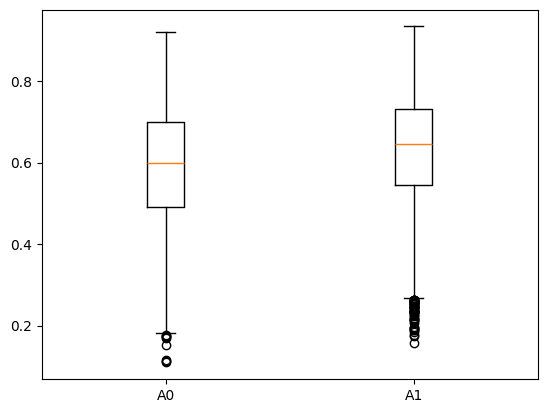

In [125]:
plt.boxplot([cam_95_0, cam_95_1], labels=['A0', 'A1'])

(array([  1.,   5.,   4.,   7.,  12.,  12.,  17.,  28.,  41.,  32.,  56.,
         68.,  98., 100., 161., 160., 231., 230., 326., 356., 386., 447.,
        478., 564., 610., 671., 675., 633., 678., 686., 658., 700., 663.,
        773., 809., 848., 932., 837., 800., 706., 549., 453., 334., 236.,
        155.,  94.,  59.,  32.,  15.,  10.]),
 array([0.15745029, 0.17298798, 0.18852568, 0.20406337, 0.21960106,
        0.23513875, 0.25067644, 0.26621413, 0.28175182, 0.29728951,
        0.3128272 , 0.32836489, 0.34390259, 0.35944028, 0.37497797,
        0.39051566, 0.40605335, 0.42159104, 0.43712873, 0.45266642,
        0.46820411, 0.48374181, 0.4992795 , 0.51481719, 0.53035488,
        0.54589257, 0.56143026, 0.57696795, 0.59250564, 0.60804333,
        0.62358103, 0.63911872, 0.65465641, 0.6701941 , 0.68573179,
        0.70126948, 0.71680717, 0.73234486, 0.74788255, 0.76342025,
        0.77895794, 0.79449563, 0.81003332, 0.82557101, 0.8411087 ,
        0.85664639, 0.87218408, 0.88772177, 0.

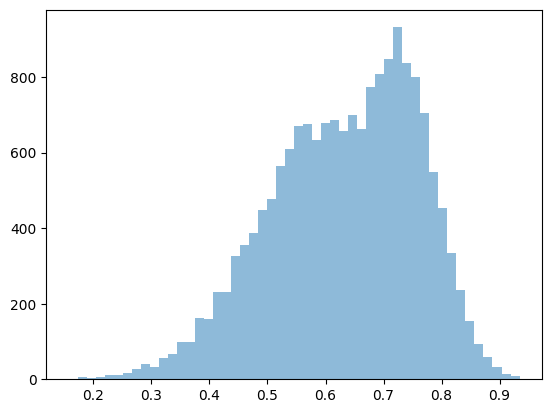

In [136]:
# plt.hist(cam_95_0, bins=50, alpha=0.5, label='A0')
plt.hist(cam_95_1, bins=50, alpha=0.5, label='A0')

In [137]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(cam_95_0, cam_95_1)
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

Mann-Whitney U test statistic: 148141675.0, p-value: 1.1210629212773803e-197


In [138]:
from scipy.stats import wilcoxon
stat, p = wilcoxon(cam_95_0, cam_95_1)
print(f'Wilcoxon符号付順位検定 p値: {p}')

ValueError: The samples x and y must have the same length.

In [134]:
# 正規分布検定
from scipy.stats import shapiro
stat_0, p_0 = shapiro(cam_95_0)
stat_1, p_1 = shapiro(cam_95_1)
print("A0 Shapiro test p-value:", p_0)
print("A1 Shapiro test p-value:", p_1)

A0 Shapiro test p-value: 9.80908925027372e-45
A1 Shapiro test p-value: 3.1837501109459844e-42


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
from scipy.stats import friedmanchisquare
# 各区間ごとにn信号分の配列を渡す
stat, p_val = Mann-Whitney U検定
python
コピーする
編集する
(values_A, values_B, values_C, values_D)

In [144]:
wilcoxon(cam_95_0, cam_95_1)

ValueError: The samples x and y must have the same length.

In [ ]:
np.unique(cam_95_0),np.unique(cam_95_1)


(array([0.10921497, 0.11348224, 0.11462723, ..., 0.91508082, 0.91773526,
        0.92005899]),
 array([0.15745029, 0.17348819, 0.17547064, ..., 0.9331524 , 0.93332132,
        0.93433485]))

In [ ]:
orage_1[all_y_true[ppg_segments.iloc[i]["signal_index"]]][0].append(tmp_0)
    data_storage_1[all_y_true[ppg_segments.iloc[i]["signal_index"]]][1].append(tmp_1)
    data_storage_1[all_y_true[ppg_segments.iloc[i]["signal_index"]]][2].append(tmp_2)
    data_stora

# kukangoto t kentei


In [ ]:
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# 各区間ごとのデータ（例：group1, group2はn_samples x n_sections配列）
# n_sections = 4
# group1 = np.array([[...], [...], ...])  # 例：shape=(n, 4)
# group2 = np.array([[...], [...], ...])

p_values = []
t_values = []
for i in range(4):
    t_stat, p_val = ttest_ind(group1[:, i], group2[:, i])
    t_values.append(t_stat)
    p_values.append(p_val)

# 多重比較補正（Bonferroni例）
reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

for i, (t_stat, p_val, p_corr, rej) in enumerate(zip(t_values, p_values, pvals_corrected, reject)):
    print(f"Section {i+1}: t={t_stat:.2f}, p={p_val:.3e}, corrected p={p_corr:.3e}, significant={rej}")


In [142]:
from scipy.stats import friedmanchisquare
# 各区間ごとにn信号分の配列を渡す
print(len(data_storage_1[0][0]),len(data_storage_1[0][1]), len(data_storage_1[0][2]), len(data_storage_1[0][3]))
stat, p_val = friedmanchisquare(data_storage_1[1][0],data_storage_1[1][1], data_storage_1[1][2], data_storage_1[1][3])
print(f"Friedman test statistic: {stat}, p-value: {p_val}")

15799 15799 15799 15799
Friedman test statistic: 17660.225653916714, p-value: 0.0


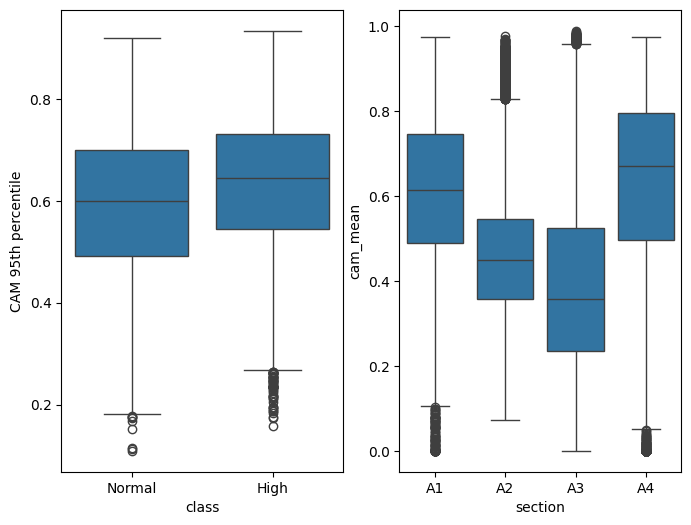

In [203]:
df2 = {
    'class': ['Normal'] * len(cam_95_0) + ['High'] * len(cam_95_1),
    'CAM 95th percentile': cam_95_0 + cam_95_1
}
import seaborn as sns
# 区間ごとのGrad-CAM値
plt.subplots(1, 2, figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='CAM 95th percentile', data=df2)
# plt.title('Comparison of 95th Percentile Grad-CAM Values')
plt.subplot(1, 2, 2)
df = {
    'section': ['A1'] * len(data_storage_1[0][0])
    + ['A2'] * len(data_storage_1[0][1]) + ['A3'] * len(data_storage_1[0][2]) + ['A4'] * len(data_storage_1[0][3])
    + ['A1'] * len(data_storage_1[1][0])
    + ['A2'] * len(data_storage_1[1][1]) + ['A3'] * len(data_storage_1[1][2]) + ['A4'] * len(data_storage_1[1][3]),
    'cam_mean': data_storage_1[0][0] + data_storage_1[0][1] + data_storage_1[0][2] + data_storage_1[0][3] + \
                data_storage_1[1][0] + data_storage_1[1][1] + data_storage_1[1][2] + data_storage_1[1][3]   }
sns.boxplot(x='section', y='cam_mean', data=df)
plt.show()
# plt.title('Mean Grad-CAM Values by PPG Interval')
plt.show()

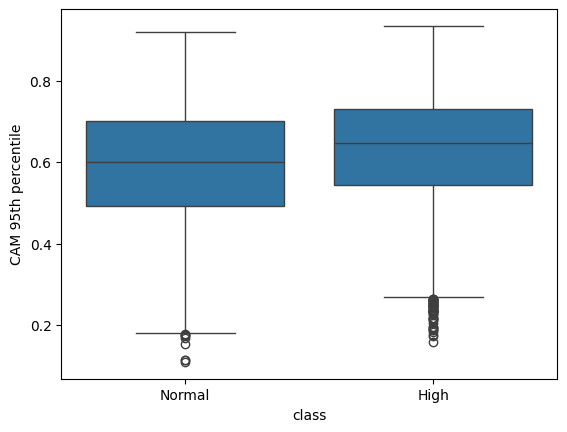

In [ ]:
# クラスごとの95パーセンタイル値



In [143]:
from scipy.stats import wilcoxon
# 例：区間1と区間3を比較
for i in range(4):
    for j in range(i + 1, 4):
        print(f"Wilcoxon test between section {i+1} and section {j+1}:")
        stat, p = wilcoxon(data_storage_1[0][i], data_storage_1[0][j])
        print(f"  Section {i+1} vs Section {j+1} - Statistic: {stat}, p-value: {p}")

Wilcoxon test between section 1 and section 2:
  Section 1 vs Section 2 - Statistic: 22112241.0, p-value: 0.0
Wilcoxon test between section 1 and section 3:
  Section 1 vs Section 3 - Statistic: 18704741.0, p-value: 0.0
Wilcoxon test between section 1 and section 4:
  Section 1 vs Section 4 - Statistic: 59177703.0, p-value: 1.7889459704180705e-08
Wilcoxon test between section 2 and section 3:
  Section 2 vs Section 3 - Statistic: 25562500.0, p-value: 0.0
Wilcoxon test between section 2 and section 4:
  Section 2 vs Section 4 - Statistic: 11806528.0, p-value: 0.0
Wilcoxon test between section 3 and section 4:
  Section 3 vs Section 4 - Statistic: 7005031.0, p-value: 0.0


In [ ]:
from statsmodels.stats.multitest import multipletests

# 例：ペアごとの生p値リスト
pvals = [0.01, 0.03, 0.07, 0.001, 0.045, 0.02]

# Bonferroni補正
reject, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')

In [ ]:
  # Welchのt検定

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


TtestResult(statistic=nan, pvalue=nan, df=38108.0)

In [ ]:
  # Welchのt検定

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


TtestResult(statistic=nan, pvalue=nan, df=38108.0)

In [133]:
# # answer 0 cam 0
# data_storage_0[0][0] = [item for sublist in data_storage_0[0][0] for item in sublist]
# data_storage_0[0][1] = [item for sublist in data_storage_0[0][1] for item in sublist]
# data_storage_0[0][2] = [item for sublist in data_storage_0[0][2] for item in sublist]
# data_storage_0[0][3] = [item for sublist in data_storage_0[0][3] for item in sublist]
# # answer 1 cam 0
# data_storage_0[1][0] = [item for sublist in data_storage_0[1][0] for item in sublist]
# data_storage_0[1][1] = [item for sublist in data_storage_0[1][1] for item in sublist]
# data_storage_0[1][2] = [item for sublist in data_storage_0[1][2] for item in sublist]
# data_storage_0[1][3] = [item for sublist in data_storage_0[1][3] for item in sublist]
# # answer 0 cam 1
data_storage_1[0][0] = [item for sublist in data_storage_1[0][0] for item in sublist]
data_storage_1[0][1] = [item for sublist in data_storage_1[0][1] for item in sublist]
data_storage_1[0][2] = [item for sublist in data_storage_1[0][2] for item in sublist]
data_storage_1[0][3] = [item for sublist in data_storage_1[0][3] for item in sublist]
# answer 1 cam 1
data_storage_1[1][0] = [item for sublist in data_storage_1[1][0] for item in sublist]
data_storage_1[1][1] = [item for sublist in data_storage_1[1][1] for item in sublist]
data_storage_1[1][2] = [item for sublist in data_storage_1[1][2] for item in sublist]
data_storage_1[1][3] = [item for sublist in data_storage_1[1][3] for item in sublist]

TypeError: 'numpy.float64' object is not iterable

Processing PPG Segments: 100%|██████████| 376408/376408 [01:22<00:00, 6275.66it/s]

In [ ]:
data_storage_0 

(array([1.20468e+06, 8.05700e+03, 2.09610e+04, 2.25560e+04, 1.76010e+04,
        1.80990e+04, 2.24400e+04, 2.13850e+04, 2.00440e+04, 2.40170e+04,
        9.76200e+03, 1.41200e+04, 9.75400e+03, 1.06140e+04, 1.28960e+04,
        6.64800e+03, 6.37100e+03, 9.53600e+03, 9.68700e+03, 1.92680e+04,
        2.15530e+04, 1.61940e+04, 1.12480e+04, 8.02500e+03, 5.62000e+03,
        3.14800e+03, 1.12840e+04, 6.46000e+03, 9.27200e+03, 7.34200e+03,
        1.03270e+04, 9.79000e+03, 7.94500e+03, 1.45470e+04, 9.74900e+03,
        1.12960e+04, 9.59700e+03, 7.98100e+03, 1.58510e+04, 7.43900e+03,
        6.46900e+03, 4.90300e+03, 4.69900e+03, 8.09200e+03, 4.91400e+03,
        8.04500e+03, 3.22800e+03, 1.57900e+03, 0.00000e+00, 4.83400e+03,
        0.00000e+00, 1.58700e+03, 1.68500e+03, 0.00000e+00, 2.85400e+03,
        6.56800e+03, 2.20000e+01, 1.54400e+03, 6.40500e+03, 2.50000e+01,
        0.00000e+00, 6.30800e+03, 1.57800e+03, 1.61900e+03, 1.63700e+03,
        0.00000e+00, 6.28600e+03, 0.00000e+00, 3.26

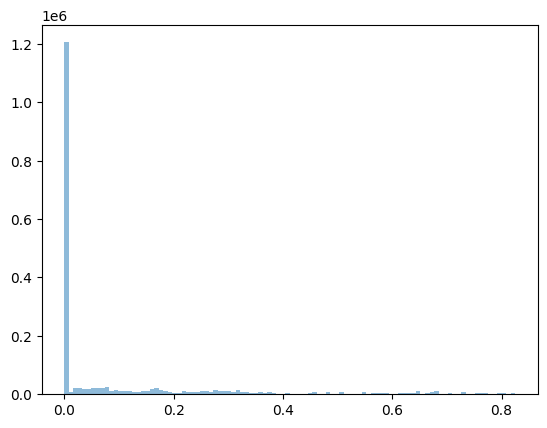

In [91]:
plt.hist(data_storage_0[0][3], bins=100, alpha=0.5, label='A0')

In [159]:
data_storage = [np.array(i) for i in data_storage_1]
print([i.shape for i in data_storage])

[(4, 15799), (4, 14719)]


In [124]:
np.unique(all_y_true, return_counts=True)

(array([0, 1], dtype=int64), array([20674, 17436], dtype=int64))

In [126]:
data_mean_00 = [np.mean(i,axis=0) for i in data_storage_0[0]]
data_std_00 = [np.std(i,axis=0) for i in data_storage_0[0]]
data_sum_00 = [np.sum(i,axis=0) for i in data_storage_0[0]]
data_median_00 = [np.median(i,axis=0) for i in data_storage_0[0]]

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [125]:
data_mean_00,data_median_00   , data_std_00, data_sum_00

([0.09306103, 0.09330719, 0.09323206, 0.09614268],
 [0.0, 0.0, 0.0, 0.0],
 [0.18171713, 0.18143009, 0.18152443, 0.18430349],
 [320806.97, 197263.81, 175693.95, 181178.95])

In [110]:
data_mean_01 = [np.mean(i,axis=0) for i in data_storage_0[1]]
data_std_01 = [np.std(i,axis=0) for i in data_storage_0[1]]
data_sum_01 = [np.sum(i,axis=0) for i in data_storage_0[1]]
data_median_01 = [np.median(i,axis=0) for i in data_storage_0[1]]

In [111]:
data_mean_01,data_median_01, data_std_01, data_sum_01

([0.09270289, 0.0930152, 0.09318569, 0.09555188],
 [0.0, 0.0, 0.0, 0.0],
 [0.18161887, 0.18119444, 0.18124267, 0.18375461],
 [217849.1, 206291.53, 175151.83, 179599.31])

In [168]:
data_mean_10 = [np.mean(i,axis=0) for i in data_storage_1[0]]
data_std_10 = [np.std(i,axis=0) for i in data_storage_1[0]]
data_sum_10 = [np.sum(i,axis=0) for i in data_storage_1[0]]
data_median_10 = [np.median(i,axis=0) for i in data_storage_1[0]]

In [169]:
data_mean_10,data_median_10, data_std_10, data_sum_10

([0.09408724, 0.09487997, 0.09533974, 0.09688002],
 [0.09406882, 0.09367318, 0.09475679, 0.096768245],
 [0.03031352, 0.034825567, 0.024036687, 0.019747384],
 [1486.4844, 1499.0087, 1506.2725, 1530.6074])

In [162]:
ttest_rel(data_storage_1[0][0], data_storage_1[1][0]) 

ValueError: unequal length arrays

In [163]:
data_mean_11 = [np.mean(i,axis=0) for i in data_storage_1[1]]
data_std_11 = [np.std(i,axis=0) for i in data_storage_1[1]]
data_sum_11 = [np.sum(i,axis=0) for i in data_storage_1[1]]
data_median_11 = [np.median(i,axis=0) for i in data_storage_1[1]]

In [164]:
data_mean_11,data_median_11, data_std_11, data_sum_11

([0.0935923, 0.09408706, 0.09534669, 0.09682066],
 [0.09294392, 0.09267191, 0.09493835, 0.09693162],
 [0.034913022, 0.03777111, 0.02631576, 0.022777868],
 [1377.5851, 1384.8674, 1403.408, 1425.1033])

In [165]:
# data_quartile_00 = [np.quantile(i,0.9,axis=0) for i in data_storage_0[0]]
# data_quartile_01 = [np.quantile(i,0.9,axis=0) for i in data_storage_0[1]]
data_quartile_10 = [np.quantile(i,0.9,axis=0) for i in data_storage_1[0]]
data_quartile_11 = [np.quantile(i,0.9,axis=0) for i in data_storage_1[1]]
data_quartile_10,data_quartile_11

([0.12124352157115936,
  0.12851123213768006,
  0.11432668119668961,
  0.11199715286493302],
 [0.12547730505466462,
  0.1286759316921234,
  0.11654189676046373,
  0.11323403865098954])

In [50]:
from scipy.stats import ttest_rel, wilcoxon, friedmanchisquare, ttest_ind, mannwhitneyu


In [92]:
ttest_ind(data_storage[1], data_storage[4]) 

IndexError: list index out of range

In [22]:
data_mean

[0.0, 0.0, 0.0, 0.0]

In [73]:
data_mean,data_median   , data_std, data_sum

([0.09291581, 0.09315765, 0.09320891, 0.095847666],
 [0.0, 0.0, 0.0, 0.0],
 [0.18167745, 0.18130963, 0.18138377, 0.18402985],
 [538655.8, 403555.12, 350845.78, 360778.28])

In [145]:
data_storage_1.shape

AttributeError: 'list' object has no attribute 'shape'

In [147]:
data.shape

AttributeError: 'list' object has no attribute 'shape'

In [152]:
len(data_storage[0])

4

In [166]:
from scipy.stats import friedmanchisquare, ttest_rel, wilcoxon

# 各行: サンプル、各列: 区間
data = data_storage[0] # shape: [n_samples, n_intervals]

# Friedman検定（全区間の分布差）
stat, p1 = friedmanchisquare(data[0], data[1], data[2], data[3])

# 例えば区間1 vs 区間3のペアt検定
t, p2 = ttest_rel(data[0], data[2])

# Wilcoxon
stat, p3 = wilcoxon(data[0], data[2])


In [167]:
stat,p1,t,p2,stat,p3

(59618263.0,
 7.038366685978773e-57,
 -3.3868865770775014,
 0.0007086295580363399,
 59618263.0,
 1.1574470656611828e-06)

## cam plot

In [64]:
i = np.random.randint(10000)
print(i)
grad_cam_plot(model,i)

4029


TypeError: grad_cam_plot() missing 1 required positional argument: 'segments'

In [65]:
plot_cam(cam,input_tensor.cpu().numpy()[0])

NameError: name 'cam' is not defined

In [ ]:
import heartpy as hp



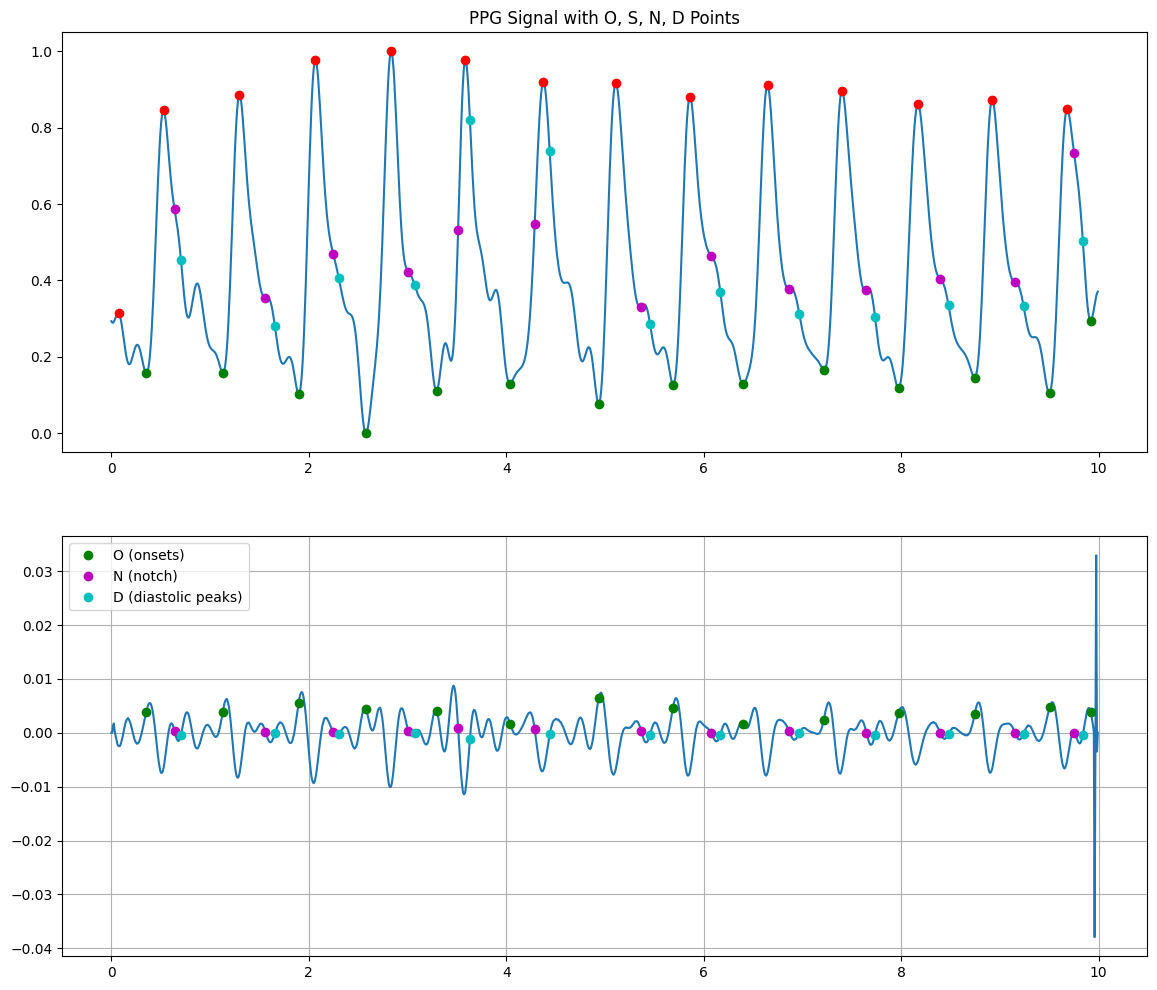

In [ ]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# サンプルのPPG波形（例としてsin波 + ノイズ）
x = test_dataset[0][0].cpu().numpy().squeeze()
# --- 平滑化（移動平均） ---
def moving_average(x, n=5):
    return np.convolve(x, np.ones(n)/n, mode='same')

y = moving_average(x, n=5)

# --- JPG (3次差分の導関数) ---
def compute_jpg(y):
    # 差分
    d = np.zeros_like(y)
    for i in range(3, len(y)-2):
        d[i] = y[i+2] - 2*y[i+1] + 2*y[i] - y[i-1]
    # 微分
    jpg = np.gradient(d)
    return jpg

jpg = compute_jpg(y)

# --- 極大値 (S) と 極小値 (O) の検出 ---
peaks_s, _ = find_peaks(x, distance=50)
peaks_o, _ = find_peaks(-x, distance=50)

# --- ゼロクロス検出（N, D候補） ---
def zero_crossings(signal):
    return np.where(np.diff(np.sign(signal)))[0]

zc = zero_crossings(jpg)
# pairs = [(o, s) for o in peaks_o for s in peaks_s if o < s]
peaks_n = []
peaks_d = []
peaks_s_in_cycle = []

# O の連続するペアを使って区間を作る
for i in range(len(peaks_o) - 1):
    o_start = peaks_o[i]
    o_end = peaks_o[i + 1]

    # O–O区間にあるS（systolic peak）の中で最大のピーク（たいてい1個）
    s_candidates = [s for s in peaks_s if o_start < s < o_end]
    if len(s_candidates) == 0:
        continue  # Sが見つからなければスキップ
    peak_s = max(s_candidates, key=lambda idx: x[idx])
    peaks_s_in_cycle.append(peak_s)

    # O–O区間のJPGゼロクロス（NとDを探す）
    zc_in_range = [z for z in zc if o_start < z < o_end]
    if len(zc_in_range) >= 4:
        peaks_n.append(zc_in_range[2])
        peaks_d.append(zc_in_range[3])
    else:
        peaks_n.append(np.nan)
        peaks_d.append(np.nan)
# # N, Dとしてゼロクロスの3番目と4番目を仮で抽出
# peaks_n = zc[2::4]  # 3番目
# peaks_d = zc[3::4]  # 4番目
t=np.arange(0,10,0.008)
# --- プロット ---
plt.figure(figsize=(14, 12))
plt.subplot(2,1,1)
plt.plot(t, x, label='PPG Signal')
plt.plot(t[peaks_s], x[peaks_s], 'ro', label='S (systolic peaks)')
plt.plot(t[peaks_o], x[peaks_o], 'go', label='O (onsets)')
plt.plot(t[peaks_n], x[peaks_n], 'mo', label='N (notch)')
plt.plot(t[peaks_d], x[peaks_d], 'co', label='D (diastolic peaks)')
plt.title('PPG Signal with O, S, N, D Points')
plt.subplot(2,1,2)
plt.plot(t,jpg)
plt.plot(t[peaks_o], jpg[peaks_o], 'go', label='O (onsets)')
plt.plot(t[peaks_n], jpg[peaks_n], 'mo', label='N (notch)')
plt.plot(t[peaks_d], jpg[peaks_d], 'co', label='D (diastolic peaks)')
plt.legend()
plt.grid(True)
plt.show()


resnet34 7,219,266,
seresnet34 7,376,450
resnet18 3,844,930
seresnet18 3,931,970

In [ ]:
from torchinfo import summary
from se_resnet1d import resnet34,se_resnet34,se_resnet18,resnet18
model = resnet18(num_classes=config["network"]["n_classes"], in_channels=config["network"]["in_channels"])
summary(model, input_size=(1, 1, 1250), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet1D (ResNet1D)                      [1, 1, 1250]              [1, 2]                    --                        True
├─Conv1d (conv1)                         [1, 1, 1250]              [1, 64, 625]              448                       True
├─BatchNorm1d (bn1)                      [1, 64, 625]              [1, 64, 625]              128                       True
├─ReLU (relu)                            [1, 64, 625]              [1, 64, 625]              --                        --
├─MaxPool1d (maxpool)                    [1, 64, 625]              [1, 64, 313]              --                        --
├─Sequential (layer1)                    [1, 64, 313]              [1, 64, 313]              --                        True
│    └─BasicBlock (0)                    [1, 64, 313]              [1, 64, 313]              --                        True
│    │ 

# compare 2 models


# get prediction

In [146]:
result1 = np.stack([np.load(f'F:\\minowa\\BloodPressureEstimation\\notebooks\\outputs\\resnet\\0415_2class_cv_res18mini2\\predictions_proba_fold{i}.npy') for i in range(5)])
result2 = np.stack([np.load(f"F:\\minowa\\BloodPressureEstimation\\repos\\hydra-bp-classifier\\checkpoints\\resnet\\0425_vit_2\\predictions_proba_fold{i}.npy") for i in range(5)])
true = np.stack([np.load(f'F:\\minowa\\BloodPressureEstimation\\notebooks\\outputs\\resnet\\0415_2class_cv_res18mini2\\true_labels_fold{i}.npy') for i in range(5)])

result1.shape,result2.shape


((5, 38110, 2), (5, 38110, 2))

In [147]:
def softmax(x):
    """
    x: shape (N, 2) のスコア配列
    出力: shape (N, 2) の確率配列（各行がソフトマックス）
    """
    # 数値安定化のため最大値を引く
    x_max = np.max(x, axis=1, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=1, keepdims=True)


In [148]:
result1= np.stack([softmax(result1[i])for i  in range(5)])
result2= np.stack([softmax(result2[i])for i  in range(5)])

In [149]:
predicted1 = np.argmax(result1,axis=2)
predicted2 = np.argmax(result2,axis=2)
np.sum(predicted1 == predicted2),np.sum(predicted1 != predicted2),np.sum(predicted1 == true),np.sum(predicted2 == true),np.sum(predicted1 != true),np.sum(predicted2 != true)

(167530, 23020, 152397, 151125, 38153, 39425)

In [150]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
acc1 = accuracy_score(true[4].flatten(), predicted1[4].flatten())
f1_1 = f1_score(true[4].flatten(), predicted1[4].flatten(), average='macro')
precision_1 = precision_score(true[4].flatten(), predicted1[4].flatten(),
    average='macro')
recall_1 = recall_score(true[4].flatten(), predicted1[4].flatten(), average='macro')
acc1, f1_1, precision_1, recall_1

(0.8062450800314878,
 0.8054343833196032,
 0.8049641571992965,
 0.8065833260151478)

In [37]:
predicted1.shape

(5, 38110)

In [175]:
f1s = []
for i in range(5):
    accuracy, class_accuracies, f1_macro = calculate_metrics(predicted1[i],true[i], classes=2)
    f1s.append(f1_macro)
averaged1 = np.mean(result1,axis=0)
print(averaged1.shape)
predicted_mean_1 = np.argmax(averaged1,axis=1)
accuracy, class_accuracies, f1_macro = calculate_metrics(predicted_mean_1,true[i], classes=2)
f1s.append(f1_macro)
f1s

NameError: name 'calculate_metrics' is not defined

In [47]:
calculate_metrics(predicted1[4],true[4], classes=2)

(0.8062450800314878,
 [0.8339867310012062, 0.7759415833973866],
 0.8054343833196032)

In [46]:
f1s = []
for i in range(5):
    accuracy, class_accuracies, f1_macro = calculate_metrics(predicted2[i],true[i], classes=2)
    f1s.append(f1_macro)
averaged2 = np.mean(result2,axis=0)
print(averaged2.shape)
predicted_mean_2 = np.argmax(averaged2,axis=1)
accuracy, class_accuracies, f1_macro = calculate_metrics(predicted_mean_2,true[i], classes=2)
f1s.append(f1_macro)
f1s

(38110, 2)


[0.792652637143646,
 0.7874932706329227,
 0.7895928627790829,
 0.794090097219593,
 0.7984063424883787,
 0.8073906237864358]

In [85]:
averaged_12 = np.mean(np.stack([averaged1,averaged2]),axis=0)
predicted_mean_12 = np.argmax(averaged_12,axis=1)
accuracy, class_accuracies, f1_macro = calculate_metrics(predicted_mean_12,true[i], classes=2)
f1_macro

0.8165640676463095

Text(33.222222222222214, 0.5, 'True')

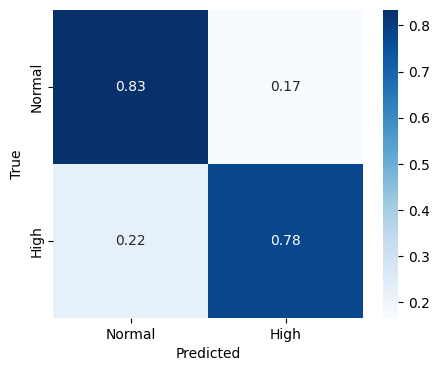

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(5,4))
cm = confusion_matrix(predicted1[4],true[4],normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap ='Blues', xticklabels=['Normal', 'High'], yticklabels=['Normal', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')

In [105]:
count = np.zeros(38110)
for i in range(5):
    wrong=(np.where(predicted1[i] != true[i])[0]) 
    count[wrong] += 1
    wrong=(np.where(predicted2[i] != true[i])[0])
    count[wrong] += 1 

Text(0, 0.5, 'Proportion of Samples')

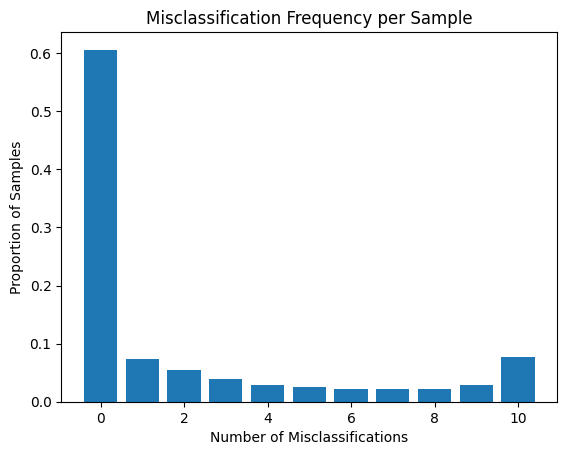

In [106]:
x,y = np.unique(count, return_counts=True)
y = y/38110
plt.bar(x,y)
plt.title('Misclassification Frequency per Sample')
plt.xlabel('Number of Misclassifications')
plt.ylabel('Proportion of Samples')

In [107]:
correct_0 = np.where(count == 0)[0]
correct_10 = np.where(count == 10)[0]
len(correct_0),len(correct_10)

(23093, 2921)

# load model here

In [180]:
from se_resnet1d import resnet18mini2
model1 = resnet18mini2(num_classes=2, in_channels=1,)
model1.load_state_dict(torch.load('..\\outputs\\resnet\\0415_2class_cv_res18mini2\\best_fold4.pth'))

<All keys matched successfully>

In [181]:
from torchinfo import summary
summary(model1, input_size=(1, 1, 1250), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet1D_Small (ResNet1D_Small)          [1, 1, 1250]              [1, 2]                    --                        True
├─Conv1d (conv1)                         [1, 1, 1250]              [1, 64, 623]              704                       True
├─BatchNorm1d (bn1)                      [1, 64, 623]              [1, 64, 623]              128                       True
├─ReLU (relu)                            [1, 64, 623]              [1, 64, 623]              --                        --
├─MaxPool1d (maxpool)                    [1, 64, 623]              [1, 64, 312]              --                        --
├─Sequential (layer1)                    [1, 64, 312]              [1, 32, 312]              --                        True
│    └─BasicBlock2 (0)                   [1, 64, 312]              [1, 32, 312]              --                        True
│    │ 

# get extracted feature (before fcn)

In [182]:
feature_extractor = nn.Sequential(*list(model1.children())[:-2])

In [183]:
data_dir = '../../data/processed/BP_npy/PulseDB'
# checkpoint_dir =config["output_path"]
batch_size = 128
test_dataset = BPDataset(data_dir,train=False)

# データセットとDataLoaderの作成
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# load checkpoint
# checkpoint_path = os.path.join(checkpoint_dir, f'best_fold{fold}.pth')
# model.load_state_dict(torch.load(checkpoint_path))
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    feature_extractor.to(device)
    feature_extractor.eval()

    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []
    # 進捗バーの設定
    val_loader_tqdm = tqdm(test_dataloader, desc=f"Fold {1}/{5} - Test", leave=False)
    for batch_idx, (x,y) in enumerate(val_loader_tqdm):
        x,y = x.to(device), y.to(device)
        outputs = feature_extractor(x)
        # _, predicted = torch.max(outputs.data, 1)
        all_y_pred_proba.extend(outputs.cpu().numpy())
        # 予測確率を取得
        # all_y_true.extend(y.cpu().numpy())
        # all_y_pred.extend(predicted.cpu().numpy())
    # all_y_true = np.array(all_y_true)
    # all_y_pred = np.array(all_y_pred)
    all_y_pred_proba = np.array(all_y_pred_proba)

torch.Size([38110, 1, 1250]) torch.Size([38110])


In [184]:
all_y_pred_proba.shape

(38110, 64, 39)

In [47]:
X_flat = all_y_pred_proba.reshape(38110, -1)  # shape: (38110, 2496)
from sklearn.preprocessing import StandardScaler    
# 2. 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

In [52]:
X_scaled_list = []
scaler = StandardScaler()

for i in range(64):
    X_channel = all_y_pred_proba[:, i, :]  # (38110, 39)
    X_channel_scaled = scaler.fit_transform(X_channel)  # チャンネルごとに標準化
    X_scaled_list.append(X_channel_scaled)

# 64チャンネル分をくっつける
X_scaled = np.concatenate(X_scaled_list, axis=1)  # (38110, 64*39) = (38110, 2496)

# t-SNEにかける
# tsne = TSNE(n_components=2, random_state=0)
# X_tsne = tsne.fit_transform(X_scaled)

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

In [88]:
points2 = TSNE(n_components=2, random_state=0,perplexity=30.0,n_iter=1000,verbose=1).fit_transform(X_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38110 samples in 0.004s...
[t-SNE] Computed neighbors for 38110 samples in 0.688s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38110
[t-SNE] Computed conditional probabilities for sample 2000 / 38110
[t-SNE] Computed conditional probabilities for sample 3000 / 38110
[t-SNE] Computed conditional probabilities for sample 4000 / 38110
[t-SNE] Computed conditional probabilities for sample 5000 / 38110
[t-SNE] Computed conditional probabilities for sample 6000 / 38110
[t-SNE] Computed conditional probabilities for sample 7000 / 38110
[t-SNE] Computed conditional probabilities for sample 8000 / 38110
[t-SNE] Computed conditional probabilities for sample 9000 / 38110
[t-SNE] Computed conditional probabilities for sample 10000 / 38110
[t-SNE] Computed conditional probabilities for sample 11000 / 38110
[t-SNE] Computed conditional probabilities for sample 12000 / 38110
[t-SNE] Computed conditional probabilities for sam

In [185]:
all_y_pred_proba = all_y_pred_proba.reshape(38110,-1)

# t-SNE


In [87]:
from sklearn.manifold import TSNE
points = TSNE(n_components=2, random_state=0,perplexity=30.0,n_iter=1000,verbose=1).fit_transform(X_scaled)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38110 samples in 0.034s...
[t-SNE] Computed neighbors for 38110 samples in 35.497s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38110
[t-SNE] Computed conditional probabilities for sample 2000 / 38110
[t-SNE] Computed conditional probabilities for sample 3000 / 38110
[t-SNE] Computed conditional probabilities for sample 4000 / 38110
[t-SNE] Computed conditional probabilities for sample 5000 / 38110
[t-SNE] Computed conditional probabilities for sample 6000 / 38110
[t-SNE] Computed conditional probabilities for sample 7000 / 38110
[t-SNE] Computed conditional probabilities for sample 8000 / 38110
[t-SNE] Computed conditional probabilities for sample 9000 / 38110
[t-SNE] Computed conditional probabilities for sample 10000 / 38110
[t-SNE] Computed conditional probabilities for sample 11000 / 38110
[t-SNE] Computed conditional probabilities for sample 12000 / 38110
[t-SNE] Computed conditional probabilities for sa

In [ ]:
cm = plt.cm.get_cmap('viridis')
plt.scatter(points[:,0],points[:,1],s=3,c=sbp,cmap=cm)
plt.colorbar()

# probability histogram

Text(0.5, 1.0, 'all samples')

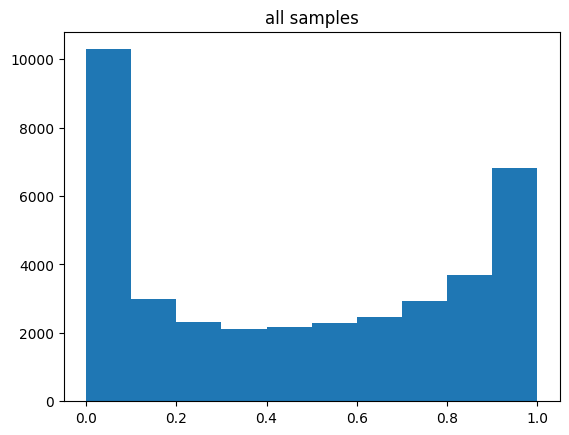

In [99]:
plt.hist(result1[4,:,1])
plt.title("all samples")


(array([9831., 2501., 1670., 1389., 1201., 1238., 1591., 2112., 2950.,
        6243.]),
 array([2.33966075e-05, 9.99989584e-02, 1.99974522e-01, 2.99950093e-01,
        3.99925649e-01, 4.99901235e-01, 5.99876761e-01, 6.99852347e-01,
        7.99827933e-01, 8.99803460e-01, 9.99779046e-01]),
 <BarContainer object of 10 artists>)

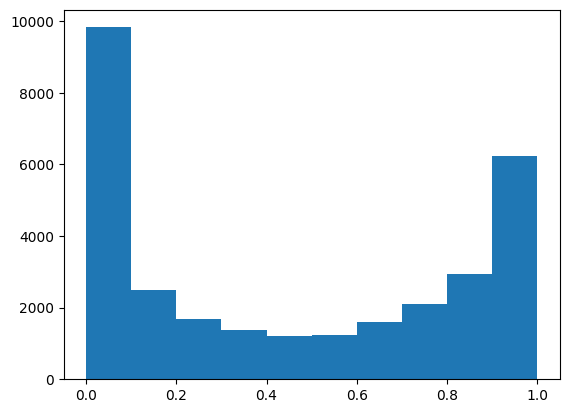

In [ ]:
plt.hist(result1[4][predicted1[4]==true[4],1])

(array([[9831., 2501., 1670., 1389., 1201., 1238., 1591., 2112., 2950.,
         6243.],
        [ 463.,  500.,  662.,  720.,  958., 1049.,  882.,  820.,  750.,
          580.]]),
 array([2.33966075e-05, 9.99989584e-02, 1.99974522e-01, 2.99950093e-01,
        3.99925649e-01, 4.99901235e-01, 5.99876761e-01, 6.99852347e-01,
        7.99827933e-01, 8.99803460e-01, 9.99779046e-01]),
 <a list of 2 BarContainer objects>)

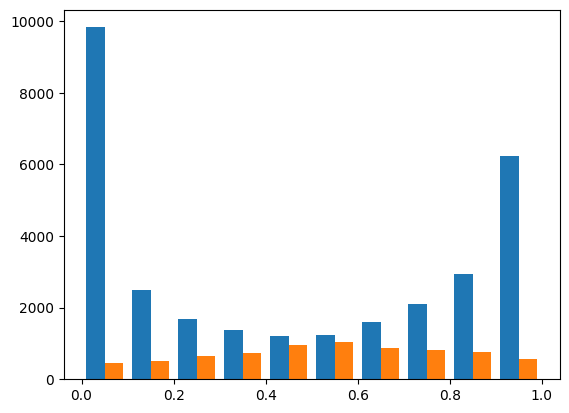

In [104]:
plt.hist([result1[4][predicted1[4]==true[4],1],result1[4][predicted1[4]!=true[4],1]])
# plt.hist()

In [61]:
result1.shape

(5, 38110, 2)

(array([   90.,   809.,  2768.,  4992.,  7529., 10064.,  7561.,  3281.,
          889.,   127.]),
 array([-4.81224823, -3.90811038, -3.00397229, -2.09983444, -1.19569647,
        -0.2915585 ,  0.61257946,  1.51671743,  2.42085528,  3.32499337,
         4.22913122]),
 <BarContainer object of 10 artists>)

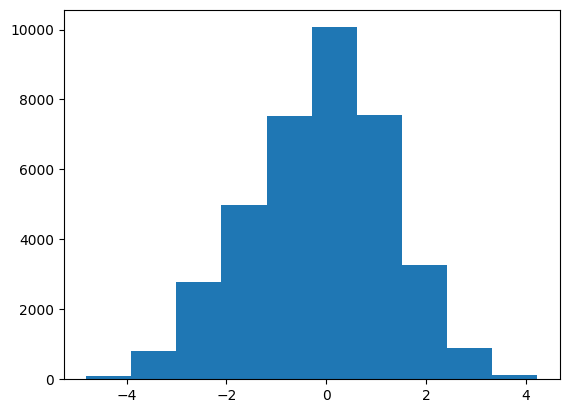

In [63]:
plt.hist(result1[4,:,1])

C:\Users\bsa\AppData\Local\Temp\ipykernel_22412\3806559734.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


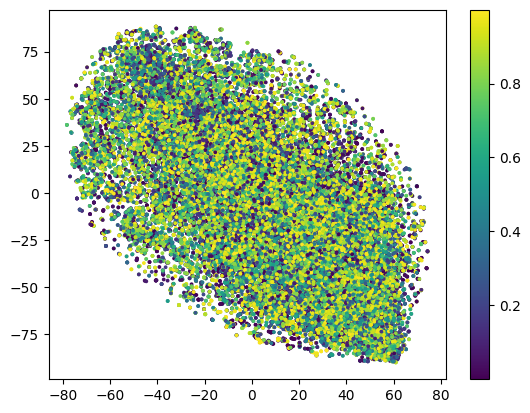

In [90]:
cm = plt.cm.get_cmap('viridis')
plt.scatter(points[:,0],points[:,1],s=3,c=result1[4,:,1],cmap=cm)
plt.colorbar()

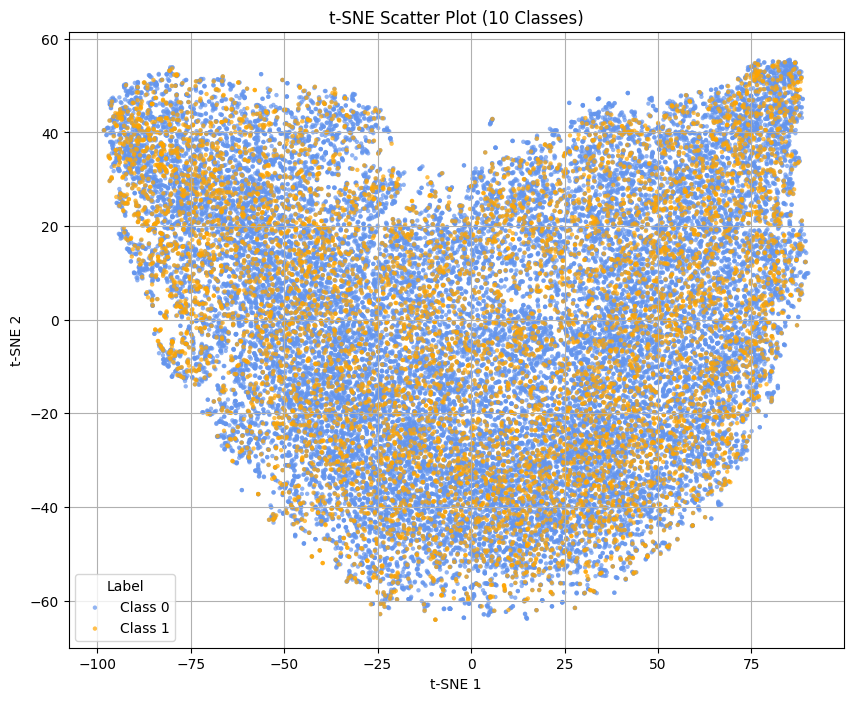

In [91]:
# カラーマップ
cmap = plt.get_cmap('tab10')  # 10色カラーマップ

plt.figure(figsize=(10, 8))
idx = (predicted1[4] == true[4])

plt.scatter(
    points2[idx, 0],
    points2[idx, 1],
    color="cornflowerblue",
    label=f'Class {0}',
    s=10,  # 点の大きさ
    alpha=0.7,  # 半透明にすると重なりがわかりやすい
    edgecolors='none'
)
idx = (predicted1[4] != true[4])
plt.scatter(
    points2[idx, 0],
    points2[idx, 1],
    color="orange",
    label=f'Class {1}',
    s=10,  # 点の大きさ
    alpha=0.7,  # 半透明にすると重なりがわかりやすい
    edgecolors='none'
)
plt.legend(title='Label', loc='best')
plt.title('t-SNE Scatter Plot (10 Classes)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

# accuracy with SBP

(262.4663300978967, 28.75585629709294)

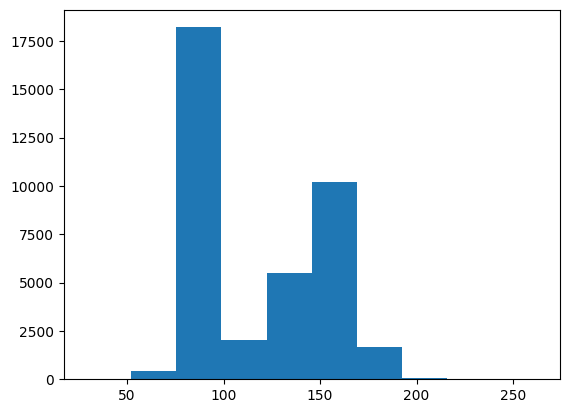

In [188]:
# accuracy with SBP
sbp = np.load(f'{data_dir}/test_sbp_2.npy')
sbp.shape
plt.hist(sbp)
sbp.max(),sbp.min()

In [186]:
all_y_true.shape,all_y_pred_proba.shape,all_y_pred.shape

AttributeError: 'list' object has no attribute 'shape'

In [191]:
np.where((sbp>119)& (sbp<121))

(array([21866], dtype=int64),)

In [194]:
result1  =np.delete(result1[4], np.where((sbp>119)& (sbp<121)), axis=0)
predicted1 = np.delete(predicted1[4], np.where((sbp>119)& (sbp<121)), axis=0)
true = np.delete(true[4], np.where((sbp>119)& (sbp<121)), axis=0)   
sbp = np.delete(sbp, np.where((sbp>119)& (sbp<121)), axis=0)

In [195]:
# bin =np.arange(20,270,10)
bin = np.arange(70, 170, 5)  # SBPの範囲に合わせてビンを設定
length = len(bin)-1
accuracy = np.zeros(length)
num_samples = np.zeros(length)
num_correct = np.zeros(length)
predict_proba_mean_0 = np.zeros(length)
predict_proba_mean_1 = np.zeros(length) 
for i in range(length):
    idx = (sbp >= bin[i]) & (sbp < bin[i+1])
    accuracy[i] = np.sum(predicted1[idx] == true[idx]) / np.sum(idx)
    num_samples[i] = np.sum(idx)
    num_correct[i] = np.sum(predicted1[idx] == true[idx])
    predict_proba_mean_0[i] = np.mean(result1[idx,0])
    predict_proba_mean_1[i] = np.mean(result1[idx,1])

C:\Users\bsa\AppData\Local\Temp\ipykernel_11088\3478213490.py:11: RuntimeWarning: invalid value encountered in scalar divide
  accuracy[i] = np.sum(predicted1[idx] == true[idx]) / np.sum(idx)
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


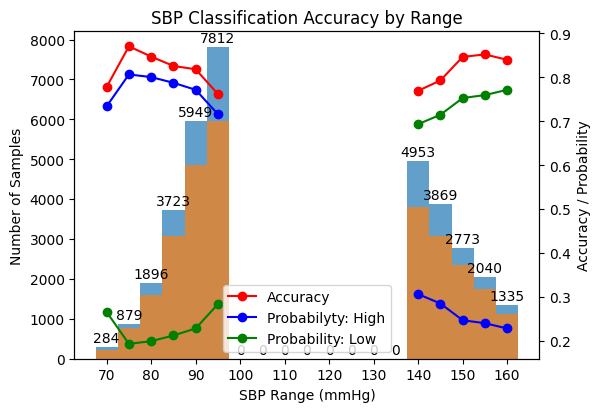

In [207]:
fig = plt.figure(figsize=(6,4.25))
ax1 = fig.add_subplot(111)
ax1.set_title('SBP Classification Accuracy by Range')
ax1.set_xlabel('SBP Range (mmHg)')
ax1.set_ylabel('Number of Samples')
ax1.bar(bin[:-1], num_samples, width=5, alpha=0.7, label='Accuracy')
# add number as text
for i, v in enumerate(num_samples):
    ax1.text(bin[i], v + 50, str(int(v)), ha='center', va='bottom')
ax1.bar(bin[:-1], num_correct, width=5, alpha=0.7, label='Accuracy')
ax1.set_xticks(bin[::2])
ax2= ax1.twinx()
ax2.set_ylabel('Accuracy / Probability')
ax2.plot(bin[:-1], accuracy, marker='o', color='red', label='Accuracy')
ax2.plot(bin[:-1], predict_proba_mean_0, marker='o', color='blue', label='Probabilyty: High')
ax2.plot(bin[:-1], predict_proba_mean_1, marker='o', color='green', label='Probability: Low')
plt.legend(loc='lower center')

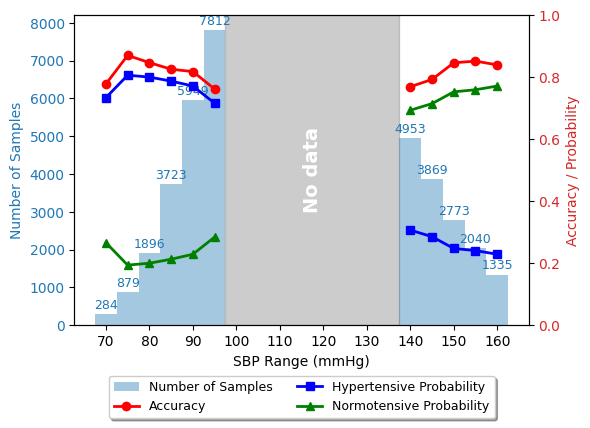

In [234]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 4.5))
ax1 = fig.add_subplot(111)
# ax1.set_title('SBP Classification Accuracy by Range')
ax1.set_xlabel('SBP Range (mmHg)')
ax1.set_ylabel('Number of Samples', color='tab:blue')

# サンプル数バー
bars = ax1.bar(bin[:-1], num_samples, width=5, alpha=0.4, color='tab:blue', label='Number of Samples', zorder=2)
for i, v in enumerate(num_samples):
    if v > 0:
        ax1.text(bin[i], v + max(num_samples)*0.009, str(int(v)), ha='center', va='bottom', fontsize=9, color='tab:blue', zorder=4)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(bin[::2])

# No data区間（例: bin 100〜140までデータなし）
no_data_start = 97.5
no_data_end = 137.5
ax1.axvspan(no_data_start, no_data_end, color='gray', alpha=0.4, zorder=1)

# 「No data」テキストを区間中央だけに表示
ax1.text((no_data_start+no_data_end)/2, ax1.get_ylim()[1]*0.5, 'No data',
         ha='center', va='center', fontsize=14, color='white', weight='bold', zorder=10, rotation=90)

# 右y軸：精度と確率
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy / Probability', color='tab:red')

ax2.plot(bin[:-1], accuracy, marker='o', color='red', label='Accuracy', linewidth=2, markersize=6, zorder=5)
ax2.plot(bin[:-1], predict_proba_mean_0, marker='s', color='blue', label='Hypertensive Probability', linewidth=2, markersize=6, zorder=5)
ax2.plot(bin[:-1], predict_proba_mean_1, marker='^', color='green', label='Normotensive Probability', linewidth=2, markersize=6, zorder=5)

ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, 1.0)  # adjust as needed

# 凡例を下中央に
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.32), ncol=2, fontsize=9, frameon=True, fancybox=True, shadow=True)

fig.tight_layout()
plt.show()


In [239]:
def plot_cam2(cam, y,title=None,segments=None):

    y=y.squeeze()
    heatmap_image = np.tile(cam, (20, 1))  # 高さ20ピクセル相当のストライプ
    fig, ax = plt.subplots(figsize=(8, 2.5))
    
    x = np.arange(0,10,0.008)
    # imshowで背景にヒートマップを表示
    ax.imshow(
        heatmap_image,
        extent=[x.min(), x.max(),y.min(), y.max() + 0.1],
        aspect='auto',
        cmap='RdYlBu_r',
        alpha=0.6,  # 透明度
        origin='lower',
        zorder=1
    )
    # ax.set_title(title)
    # 波形のプロット
    ax.plot(x, y, color='black')
    ax.set_xlim(x.min(), x.max())
    # iterate the df row
    if segments is not None:
        feature_points = [
            ("A0", "red",    "o", "foot"),
            ("A1", "blue",   "s", "VPG peak"),
            ("A2", "green",  "^", "systolic peak"),
            ("A3", "orange", "D", "diastolic peak"),
            ("A4", "red", "o", "foot")
        ]

        # すでに追加したラベルの一覧（重複防止用）
        added_labels = set()
        for i in range(len(segments)):
            segment = segments.iloc[i]
            # print(segment)
            # paint the area between A1 and A2
            # ax.axvspan(x[segment["A0"]], x[segment["A1"]],ymax=0.1,ymin=-0.1, color='pink', alpha=0.3, label='A0-A1 Segment',zorder=3)
            # ax.axvspan(x[segment["A1"]], x[segment["A2"]],ymax=0.1,ymin=-0.1, color='blue', alpha=0.3, label='A1-A2 Segment',zorder=3)
            # ax.axvspan(x[segment["A2"]], x[segment["A3"]],ymax=0.1,ymin=-0.1, color='orange', alpha=0.3, label='A2-A3 Segment',zorder=3)
            # ax.axvspan(x[segment["A3"]], x[segment["A4"]],ymax=0.1,ymin=-0.1, color='green', alpha=0.3, label='A3-A4 Segment',zorder=3)

            for key, color, marker, label in feature_points:
                # 最初の1回だけラベルをつける（重複防止）
                show_label = label if label not in added_labels else ""
                ax.scatter(
                    x[segment[key]], y[segment[key]],
                    color=color, marker=marker, s=15,
                    label=show_label, zorder=5
                )
                # plot vertical line
                ax.axvline(x=x[segment[key]], color="black", linestyle='--', linewidth=0.5, zorder=4)
                if x[segment[key]] < 0.4 or x[segment[key]] > 1.75:
                    continue
                elif key != "A0":
                    key_prev = "A"+str(int(key[1])-1)
                    ax.text(
                        ((x[segment[key]]+x[segment[key_prev]])/2), 1.0,
                        f"{key}",
                        color="black", fontsize=8, ha='center', va='bottom', zorder=6
                    )
                added_labels.add(label)

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=4, fontsize=9, frameon=True, fancybox=True, shadow=True)
    ax.set_xlim(0.4,1.75)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    # plt.tight_layout()
    plt.show()

In [212]:
def grad_cam_plot(model,idx,segments):
    grad_cam = GradCAM(model=model, feature_layer=model.basicblock_list[-1])
    input_tensor = test_dataset[idx][0].unsqueeze(0).to(device)
    print("true:",test_dataset[idx][1].cpu().numpy(),"pred:",grad_cam.forward(input_tensor),nn.Softmax(dim=1)(grad_cam.forward(input_tensor)))
    model_output = grad_cam.forward(input_tensor)
    target = model_output.argmax(1).item()
    grad_cam.backward_on_target(model_output, target)
    # Get feature gradient
    feature_grad = grad_cam.feature_grad.data.cpu().numpy()[0]
    print(feature_grad.shape)
    # Get weights from gradient
    weights = np.mean(feature_grad, axis=1)  # Take averages for each gradient
    # Get features outputs
    feature_map = grad_cam.feature_map.data.cpu().numpy()
    grad_cam.clear_hook()
    cam = np.sum((weights * feature_map.T), axis=1).T
    cam = np.maximum(cam, 0)  # apply ReLU to cam
    cam = (cam-cam.min())/(cam.max()-cam.min())
    # segments with same signal_idx
    segments = segments[segments["signal_index"] == idx]
    plot_cam2(cam,input_tensor.cpu().numpy()[0],title=f"true:{test_dataset[idx][1].cpu().numpy()},pred:{nn.Softmax(dim=1)(grad_cam.forward(input_tensor)).detach().cpu().numpy()[0]}",segments=segments)

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


true: 1 pred: tensor([[-0.4204,  0.2248]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[0.3441, 0.6559]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
(128, 1250)


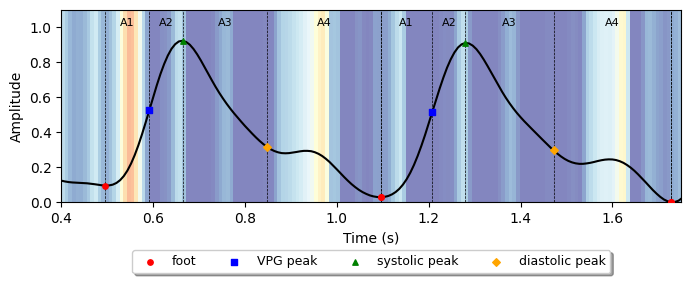

In [240]:
grad_cam_plot(model,100,ppg_segments)

# lda

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# X: 特徴量 (N, D)
# y: ラベル (-1 or 2)

lda = LinearDiscriminantAnalysis(n_components=1)  # 2クラスだから最大1軸
X_lda = lda.fit_transform(X_scaled, true[4])


In [95]:
X_lda.shape

(38110, 1)

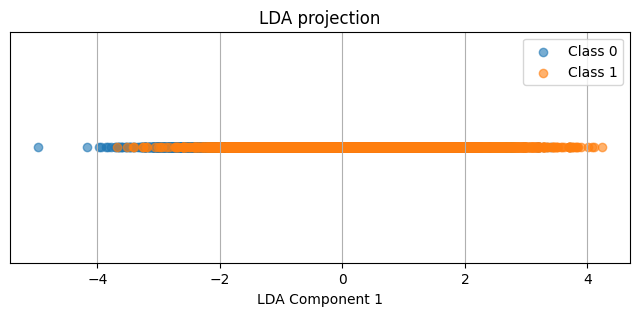

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# 仮に
# X_lda: (N, 1) の配列（LDA後の特徴量）
# y_true: (N,) の正解ラベル（-1 or 2）

# x軸用
x = X_lda.squeeze()  # (N,) にする
# y軸用 (全部0)
y = np.zeros_like(x)

# プロット
plt.figure(figsize=(8, 3))

# クラスごとに色分け
for label in np.unique(true[4]):
    plt.scatter(
        x[true[4] == label],
        y[true[4] == label],
        label=f"Class {label}",
        alpha=0.6
    )

plt.xlabel("LDA Component 1")
plt.yticks([])  # y軸は消す（1次元なので意味ない）
plt.legend()
plt.title("LDA projection")
plt.grid(True)
plt.show()